# Final Project: Stellar label transfer from APOGEE to optical SDSS spectra using a neural net
## Preamble
Stellar labels (we define "stellar labels" to mean scalar properties of a celestial objects, which can be related to observations of the object) are of great interest in astronomy, being a central part of many derivations and conclusions. Deriving more accurate stellar models, as well as questioning the values and accuracy of established labels, is therefore important. In this project, we intend to do a bit of both, by creating a rivaling set of labels to the ones derived through the SSPP pipeline for optical SDSS spectra. This will be done by cross-matching stars between the optical SDSS surveys, and the infrared APOGEE survey. Under the assumption that the ASPCAP derived labels for the APOGEE stars are of higher quality than their SSPP counterpart, we can train a neural network with the optical spectra as input, and the ASPCAP labels as output. We will then be left with a label-predicting model trained on entirely different data than the SSPP labels.

We are very depedent on finding enough stars in both surveys to establish a good baseline for our model. We found no literature describing such a crossmatch, and it will need to be done relatively manually. The stars must also cover label space well enough to make meaningful predictions about relevant stars. If these requirements are satisfied, we should be able to train a neural net to establish a rivaling label prediction model. Comparing this model to SSPP established label values is the main goal of this project. If we can create a model which gives label values closer to ASPCAP than SSPP values, an argument can be made for the derived values being better than the SSPP ones. Either way, having an alternate label set is of great interest in and of itself. As an extra bonus, simply the crossmatching of SSPP and ASPCAP might be very intrestering, as it could reveal biases between the two pipelines.

As the project has come to an end, the final results are very much in line with the original goals of the project. Enough stars were found, and they covered label space well. The desired results were also achived, and a good model was build, predicting values lying closer to ASPCAP than those of SSPP. A clear bias was also found in one label (effective temperature). No de-scope of any kind was necessary.

# 1. Introduction
As stated above, we will attempt to create a rivaling label set to that of SSPP. Specifically, we will be using effective temperature (Teff), surface gravity (Log(g)), and metallicity (Fe/H) as our stellar labels, but the model could easially be expanded to more labels. Abundances would be of special interest. One reason this was not done, was because abundancy values were avaliable for fewer stars than our three main labels, which would reduce the size of our (already pretty small) dataset.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import corner
import scipy.interpolate
import astropy
import seaborn as sns
# import mpld3
# mpld3.enable_notebook()
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from astroquery.sdss import SDSS
from tqdm import trange
from astropy.io import fits
from os import listdir
from os.path import isfile, join
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 9
mpl.rcParams['legend.fontsize'] = 'Large'
mpl.rcParams['figure.titlesize'] = 'Small'

np.random.seed(1942)

Using TensorFlow backend.


# 2. Data Extraction 
## 2.1 Extracting APOGEE ra/dec, IDs, and labels

APOGEE provies lots of nice information about all their surveyed stars contained in a single fits file. Parsing through this, we extract position and label information. We then discard any star which doesn't have avaliable label information for our three chosen labels. All information is stored in a Pandas DataFrame object.

In [2]:
filename = "allStar-l31c.2.fits"
with fits.open(filename) as infile:
    data = infile[1].data
    N = len(infile[1].data)
    
    allAPOGEE = pd.DataFrame()
    allAPOGEE['dec'] = data['DEC']
    allAPOGEE['ra'] = data['RA']
    allAPOGEE['Teff'] = data['TEFF']
    allAPOGEE['Teff_err'] = data['TEFF_ERR']
    allAPOGEE['logg'] = data['LOGG']
    allAPOGEE['logg_err'] = data['LOGG_ERR']
    allAPOGEE['FeH'] = data['FE_H']
    allAPOGEE['FeH_err'] = data['FE_H_ERR']
    allAPOGEE['OFE'] = data['O_FE']
    allAPOGEE['OFE_err'] = data['O_FE_ERR']
    allAPOGEE['SiFe'] = data['SI_FE']
    allAPOGEE['SiFe_err'] = data['SI_FE_ERR']
    allAPOGEE['target_id'] = data['TARGET_ID']

cut_idx = (allAPOGEE['Teff'] != -9999.) & (allAPOGEE['logg'] != -9999.) & (allAPOGEE['FeH'] != -9999.)
allAPOGEE = allAPOGEE[cut_idx].reset_index(drop=True)
label_names = ["Teff", "Log(g)", "FeH"]
N = len(allAPOGEE['Teff'])

## 2.2 Finding crossmatching stars
Matching the catalogs was quite the hazzle, but in the end, the SDSS module of Astroquery pulled through. It was incredibly buggy, refusing to search at multiple coordinates simultaniously (is should be capable, it just crashes), and the ~200'000 stars were searches for seperatly in a loop. The code is commented out below, and was run throughout the night. The indexes of matching stars saves to an array. Afterwards, the matches can be traversed quickly, as this number is considerably smaller.

The SDSS "get_spectra" method by default searches a 2 arcsecond radius around a chosen location. This value seemed reasonable, and was left at default. The search resulted in a total of 425 stars.

In [3]:
# coords = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')

# match_idxs = []
# for i in trange(len(coords)):
#     try:
#         SDSS_table = SDSS.get_spectra(coords[i])
#         if SDSS_table is not None:
#             match_idxs.append(i)
#     except:
#         pass
# np.save(f"match_idxs.npy", np.array(match_idxs))

## 2.3 Loading spectra
Below, we have loaded the specra of the 425 stars. We then loaded the spectra for these stars with the SDSS module, and discarded any star with all-zero magnitudes. This left us with 419 stars and spectra.

Below this, we have plotted the location and labels of these stars, compared to all of APOGEE. In the first figure, we show ra/dec, while the other plots show how our stars cover label space, compared to all of APOGEE. As we can see, our label-density is very nice and uniform, and we cover label space pretty well.

In [4]:
match_idxs = np.load("match_idxs.npy")
nr_stars = len(match_idxs)
APOGEE = allAPOGEE.iloc[match_idxs].reset_index(drop=True)

In [5]:
specs = []
coords = astropy.coordinates.SkyCoord(ra=APOGEE['ra'], dec=APOGEE['dec'], unit='deg', frame='icrs')
for i in trange(nr_stars):
    specs.append(SDSS.get_spectra(coords[i]))

100%|██████████| 425/425 [00:03<00:00, 110.93it/s]


In [6]:
wls = []
mags = []
mags_err = []
specids = []
nr_bad_pix = []
cut_idx = np.zeros(nr_stars, dtype=bool)

for i in trange(nr_stars):
    wl = []
    mag = []
    model = []
    mag_err = []
    spec = specs[i][0][1].data
    for j in range(len(spec)):
        mag.append(spec[j][0])
        mag_err.append(spec[j][2])
        wl.append(10**(spec[j][1]))
    if (np.array(mag) != 0).any():  # Some stars have zero magnitude all over. Ignore those.
        wls.append(np.array(wl))
        mags.append(np.array(mag))
        mags_err.append(np.array(mag_err))
        specids.append(specs[i][0][0].header['SPEC_ID'])
        nr_bad_pix.append(specs[i][0][0].header['FBADPIX'])
        cut_idx[i] = True

nr_stars = len(wls)
APOGEE = APOGEE[cut_idx].reset_index(drop=True)
print(f"Retrieved {nr_stars} spectra from SDSS.")

100%|██████████| 425/425 [03:25<00:00,  2.11it/s]

Retrieved 422 spectra from SDSS.


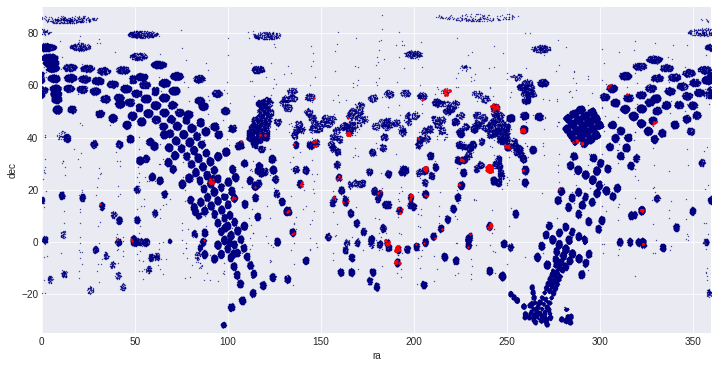

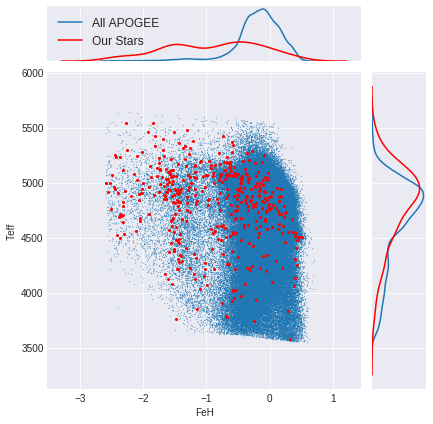

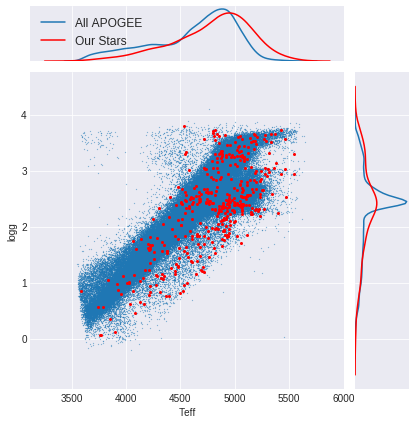

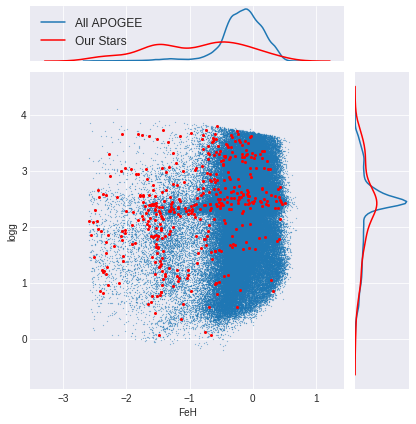

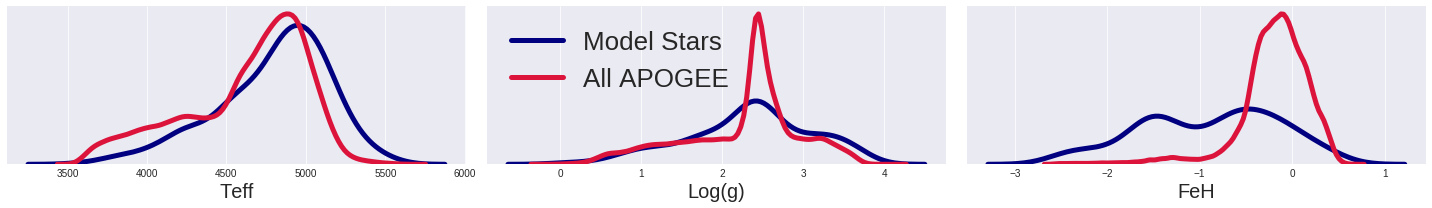

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(allAPOGEE['ra'], allAPOGEE['dec'], s=0.1, c="navy", label="All APOGEE")
plt.scatter(APOGEE['ra'], APOGEE['dec'], s=2, c="red", label="Our Stars")
plt.xlabel("ra"); plt.ylabel("dec");
plt.xlim(0, 360); plt.ylim(-35, 90);

g = sns.JointGrid(allAPOGEE['FeH'], allAPOGEE['Teff'])
sns.kdeplot(allAPOGEE['FeH'], ax=g.ax_marg_x, label="All APOGEE")
sns.kdeplot(allAPOGEE['Teff'], ax=g.ax_marg_y, vertical=True, label="")
sns.kdeplot(APOGEE['FeH'], ax=g.ax_marg_x, c="red", label="Our Stars")
sns.kdeplot(APOGEE['Teff'], ax=g.ax_marg_y, vertical=True, c="red", label="")
g.ax_joint.plot(allAPOGEE['FeH'], allAPOGEE['Teff'], "o", ms=0.2)
g.ax_joint.plot(APOGEE['FeH'], APOGEE['Teff'], "o", ms=2, c="red")

g = sns.JointGrid(allAPOGEE['Teff'], allAPOGEE['logg'])
sns.kdeplot(allAPOGEE['Teff'], ax=g.ax_marg_x, label="All APOGEE")
sns.kdeplot(allAPOGEE['logg'], ax=g.ax_marg_y, vertical=True, label="")
sns.kdeplot(APOGEE['Teff'], ax=g.ax_marg_x, c="red", label="Our Stars")
sns.kdeplot(APOGEE['logg'], ax=g.ax_marg_y, vertical=True, c="red", label="")
g.ax_joint.plot(allAPOGEE['Teff'], allAPOGEE['logg'], "o", ms=0.2)
g.ax_joint.plot(APOGEE['Teff'], APOGEE['logg'], "o", ms=2, c="red")

g = sns.JointGrid(allAPOGEE['FeH'], allAPOGEE['logg'])
sns.kdeplot(allAPOGEE['FeH'], ax=g.ax_marg_x, label="All APOGEE")
sns.kdeplot(allAPOGEE['logg'], ax=g.ax_marg_y, vertical=True, label="")
sns.kdeplot(APOGEE['FeH'], ax=g.ax_marg_x, c="red", label="Our Stars")
sns.kdeplot(APOGEE['logg'], ax=g.ax_marg_y, vertical=True, c="red", label="")
g.ax_joint.plot(allAPOGEE['FeH'], allAPOGEE['logg'], "o", ms=0.2)
g.ax_joint.plot(APOGEE['FeH'], APOGEE['logg'], "o", ms=2, c="red");

fig, ax = plt.subplots(1, 3, figsize=(20,3))
for i, l in enumerate(['Teff', 'logg', 'FeH']):
    sns.distplot(APOGEE[l], hist=False, ax=ax[i], label="Model Stars", color="navy", kde_kws={'linewidth':5})
    sns.distplot(allAPOGEE[l], hist=False, ax=ax[i], label="All APOGEE", color="crimson", kde_kws={'linewidth':5})
    ax[i].set_xlabel(label_names[i], fontsize=20)
    ax[i].legend('')
ax[1].legend(fontsize=26)
plt.setp(ax, yticks=[])
plt.tight_layout();

## 2.4 Cutting the optical SDSS spectra
Turns out, the SDSS spectra are not aligned, in the sense that the first and last pixel wavelengths of each spectra vary quite a lot. After studying the wavelength distributions we luckily discover that they are actually lined up, in the sense that in overlapping areas, the wavelengths are exactly corresponding. It just hapens that some spectra expand further than others. This is probably the result of doppler-correction of the spectra. Luckily, this means that we simply need to crop all spectra to the highest start and lowest end wavelength of all our collected spectra. This is done below.

We also calculated average signal to noise ratio for all spectra, where the lowest fell on SNR=79. This seems decent enough that removing spectr based on SNR seems unnecessary, especially considering we don't have too much data.

In [8]:
wl_min, wl_max = 1e10, 0
for i in range(nr_stars):
    if wls[i].min() < wl_min:
        wl_min = wls[i].min()
    if wls[i].max() > wl_max:
        wl_max = wls[i].max()

wl_start, wl_stop = 0, 1e10
for i in range(nr_stars):
    if wls[i][-1].min() < wl_stop:
        wl_stop = wls[i][-1].min()
    if wls[i][0].max() > wl_start:
        wl_start = wls[i][0].max()
    
print(f"The shortest and longest found wavelengths were {wl_min:.1f} and {wl_max:.1f}, respectively.")
print(f"The chosen start and end points for our spectra are {wl_start:.1f} and {wl_stop:.1f}, respectively.")

The shortest and longest found wavelengths were 3788.8 and 9240.6, respectively.
The chosen start and end points for our spectra are 3944.6 and 8990.8, respectively.


In [9]:
for i in range(nr_stars):
    cut_idx2 = np.argwhere( (wl_start < wls[i]) & ( wls[i] < wl_stop))[:,0]
    wls[i] = wls[i][cut_idx2]
    mags[i] = mags[i][cut_idx2]
    mags_err[i] = mags_err[i][cut_idx2]

wl = np.array(wls[-1]); mags = np.array(mags); mags_err = np.array(mags_err)
del wls;  # all wavelengths are the same now, no need to keep them seperate.
mags_err[mags_err == 0] = mags[mags_err == 0]*0.2
SNR = np.mean(mags/mags_err, axis=1)
nr_pixels = len(wl)
print(f"After aligning all spectra, we are left with {nr_pixels} pixels.")
print(f"The minumum signal to noise ratio found was {SNR.min():.1f}")

After aligning all spectra, we are left with 3577 pixels.
The minumum signal to noise ratio found was 79.3


## 2.5 Reading SSPP labels
Now that the spectra and APOGEE labels are in order, we would like to load the SSPP labels, to be able to perform some sanity checking on the data we have collected. Remember, the only criteria we have so far imposed on matching stars between the surveys has been a 2 arcsec proximity. There is no guarantee these are actually the same stars.

Below, we parse the SSPP file provided by SDSS, containing, among other things, SSPP derived labels for the optical spectra. 55 of the 419 stars does not have SSPP provided labels, which make them harder to sanity check.

Before we dive into that, let's take a quick look at how our stars compare to the SSPP label space. Below, we have included all SSPP stars in the label space distribution. It's very apparent that we don't cover this label space as well as we did APOGEE, especially not in Log(g) and Teff. SDSS optical surveys seems to have targeted warmer and heavier stars than APOGEE does. Especially in Log(g), the surveys seems almost non-overlapping. I don't really know enough about the stars contained in each survey and how they are chosen to comment on this. The difference will of course limit our prediction capabilities to SDSS stars withing our label space, but SDSS also has a lot of optical spectra, so there should be plenty.

In [11]:
filename = "ssppOut-dr12.fits"
with fits.open(filename) as infile:
    data = infile[1].data
    idxs = np.zeros(nr_stars, dtype=int)
    allSSPP = pd.DataFrame()
    allSSPP['Teff'] = data['TEFF_ADOP']
    allSSPP['logg'] = data['LOGG_ADOP']
    allSSPP['FeH'] = data['FEH_ADOP']
    for i in trange(nr_stars):
        idxs[i] = np.argwhere(specids[i] == data['SPECOBJID'])[0]
   
    SSPP = pd.DataFrame()
    for l in ['Teff', 'logg', 'FeH']:
        SSPP[f'{l}'] = data[f'{l}_ADOP'][idxs]
        SSPP[f'{l}_err'] = data[f'{l}_ADOP_UNC'][idxs]
    for l in ['ra', 'dec', 'BV', 'V_mag', 'G_mag']:
        SSPP[f'{l}'] = data[f'{l}'][idxs]

allSSPP[allSSPP == -9999.] = np.nan
SSPP[SSPP == -9999.] = np.nan        

for l in ['Teff', 'logg', 'FeH', 'ra', 'dec']:
    SSPP[f'{l}_diff'] = SSPP[f'{l}'] - APOGEE[f'{l}']

print(f"The SSPP labeled SDSS files matching APOGEE stars contains {np.sum(np.isnan(SSPP['Teff']))} NaNs.");

100%|██████████| 422/422 [00:19<00:00, 21.67it/s]


The SSPP labeled SDSS files matching APOGEE stars contains 55 NaNs.


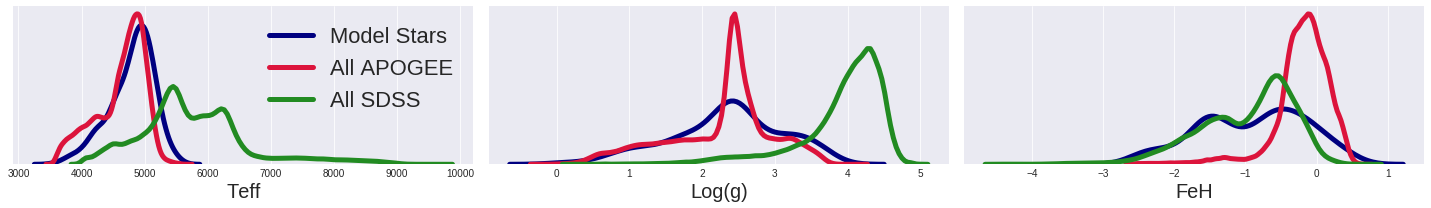

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,3))
for i, l in enumerate(['Teff', 'logg', 'FeH']):
    sns.distplot(APOGEE[l], hist=False, ax=ax[i], label="Model Stars", color="navy", kde_kws={'linewidth':5})
    sns.distplot(allAPOGEE[l], hist=False, ax=ax[i], label="All APOGEE", color="crimson", kde_kws={'linewidth':5})
    sns.distplot(allSSPP[l], hist=False, ax=ax[i], label="All SDSS", color="ForestGreen", kde_kws={'linewidth':5})
    ax[i].set_xlabel(label_names[i], fontsize=20)
    ax[i].legend('')
ax[0].legend(fontsize=22)
plt.setp(ax, yticks=[])
plt.tight_layout();

## 2.6 Cuts
Now, confirming which stars are actually the same between surveys is a challenging task. We will here only make a pretty simple attempt at removing the worst outliers, because we are pretty confident we got the right stars just from the ra/dec search. This confidence comes from the fact that 2 arcseconds is not a whole lot. If my math checks out, a sphere contains something like $10^{10}$ 2 arcsecond circles, making it unlikely to catch a star by chance when probing a random location, even with several million surveyed stars hanging around. We can also see this from the first plot below, where the ra and dec displacement of found stars are plotted (aka. what is the ra/dec offset between SSPP and APOGEE for what we believe is the same 419 stars). If our search was merely hitting random stars, we would see randomly distributed displacements, while they are in fact very concentrated around the origin.

We therefore propose a very simple distance metric. First, we define a label distance metric by scaling the APOGEE/SSPP difference with the standard diviation of all respective APOGEE labels (e.g. $\sigma_{Teff}$ is the std of the set of all Teff values in our stars). The angular distance, in arcseconds is also included. The distance between two stars in this metric is thus defined:

\\[
    D(\Delta Teff, \Delta logg, \Delta FeH, \Delta d) = \frac{\Delta Teff}{\sigma_{Teff}} + \frac{\Delta logg}{\sigma_{logg}} + 2\frac{\Delta FeH}{\sigma_{FeH}} + 2\Delta d
\\]
where $d$ is anglular distance, in arcseconds. In other words, in our metric, a distance of one arcsecond corresponds to a distance of one standard diviation FeH, which corresponds to half a standard diviation in Teff or Log(g). Metallicity is given twice the "penalty" as the two other labels, because it generally holds much lower standard errors, and should be more accurate (see more below).

Now, a handful of the stars doesn't have SSPP labels. The distance in these were simply set to one standard diviation distance from ASPCAP values, in all labels.

This metric is obviously very arbritrary, but we are, as mentioned, pretty confident in our set of stars, and coming up with a solid metric is difficult. Hopefully we can catch the worst outliers.

### 2.6.1 Results
Removing all stars which has a distance metric of more than 4.5 between ASPCAP and SSPP removes 26 of our 419 stars. The value of 4.5 was chosen by trial and error, adjusting until the most visible outliers were removed. 

Below, we show what stars were removed (colored red), as well as the general outlie of both angular and label relations. The first plot shows the displacement in ra and dec between SSPP and APOGEE, where they are colored after their distance in our arbritrary metric. We see that most of the stars which did not agree well in position were removed.

Below this, we show the relation between ASPCAP and SSPP label values, with errorbars(SSPP vertically, and ASPCAP horizontally). Also here, removed stars are shown in red. Especially one thing is very noticable from these plots. SSPP very consistently overestimates effective temperature compared to ASPCAP. This is a very interesting observation, and possibly allows our model to outperform SSPP in Teff, given that we believe ASPCAP values to be more correct.

In [13]:
Teff_diff = 1*np.abs(APOGEE['Teff'] - SSPP['Teff'])/np.std(APOGEE['Teff'])
Teff_diff[np.isnan(Teff_diff)] = 1
logg_diff = 1*np.abs(APOGEE['logg'] - SSPP['logg'])/np.std(APOGEE['logg'])
logg_diff[np.isnan(logg_diff)] = 1
FeH_diff = 2*np.abs(APOGEE['FeH'] - SSPP['FeH'])/np.std(APOGEE['FeH'])
FeH_diff[np.isnan(FeH_diff)] = 2
angle_diff = 2*np.abs(np.sqrt( (APOGEE['ra'] - SSPP['ra'])**2 + (APOGEE['dec'] - SSPP['dec'])**2))*3600
angle_diff[np.isnan(angle_diff)] = 2
SSPP['label_diff'] = Teff_diff + logg_diff + FeH_diff
SSPP['label_angle_diff'] = Teff_diff + logg_diff + FeH_diff + angle_diff

idx_highdiff = np.argwhere(SSPP['label_angle_diff'] >= 4.5).T[0]
idx_lowdiff = np.argwhere(SSPP['label_angle_diff'] < 4.5).T[0]

print(f"The current cut removes {len(idx_highdiff)} stars from the set.")

The current cut removes 26 stars from the set.


 166.8,  115.4 
 0.065,  0.247 
-0.012,  0.118


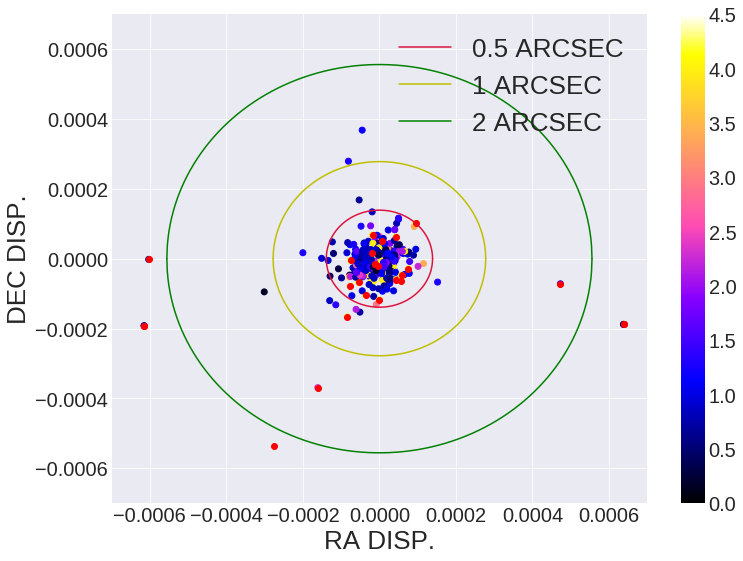

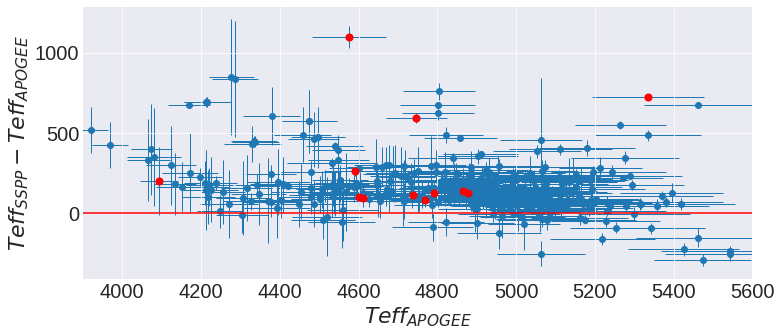

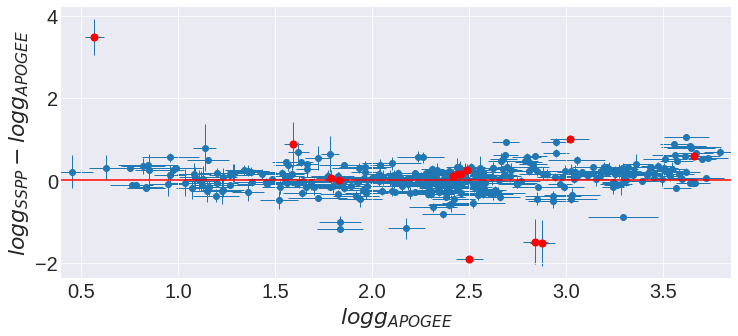

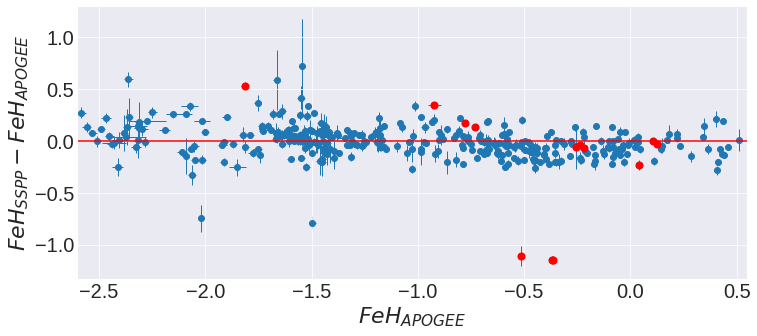

In [14]:
plt.figure(figsize=(12,9))
mpl.rc('xtick', labelsize=20)     
mpl.rc('ytick', labelsize=20)
sc = plt.scatter(SSPP['ra_diff'], SSPP['dec_diff'], c=SSPP['label_diff'], cmap='gnuplot2', vmin=0, vmax=4.5, label="")
cut_idx = np.isnan(SSPP['Teff'])
plt.scatter(SSPP['ra_diff'].iloc[idx_highdiff], SSPP['dec_diff'].iloc[idx_highdiff], c='red', label="")
plt.xlim(-0.0007, 0.0007)
plt.ylim(-0.0007, 0.0007)
x = np.linspace(-(0.5/3600), (0.5/3600), 1001)
plt.plot(x, np.sqrt((0.5/3600)**2 - x**2), c="crimson", label="0.5 ARCSEC")
plt.plot(x, -np.sqrt((0.5/3600)**2 - x**2), c="crimson")
x = np.linspace(-1.0/3600, 1.0/3600, 1001)
plt.plot(x, np.sqrt((1.0/3600)**2 - x**2), c="y", label="1 ARCSEC")
plt.plot(x, -np.sqrt((1.0/3600)**2 - x**2), c="y")
x = np.linspace(-2.0/3600, 2.0/3600, 1001)
plt.plot(x, np.sqrt((2.0/3600)**2 - x**2), c="g", label="2 ARCSEC")
plt.plot(x, -np.sqrt((2.0/3600)**2 - x**2), c="g")
plt.colorbar(sc);
plt.xlabel("RA DISP.", fontsize=26)
plt.ylabel("DEC DISP.", fontsize=26)
plt.legend(fontsize=26, loc=1);
label_xlims = [[3900, 5600], [0.4, 3.85], [-2.6, 0.55]]

plt.figure(figsize=(12,5))
plt.scatter(APOGEE['Teff'], SSPP['Teff_diff'])
plt.scatter(APOGEE['Teff'].iloc[idx_highdiff], SSPP['Teff_diff'].iloc[idx_highdiff], c="r", s=50, zorder=1)
plt.errorbar(APOGEE['Teff'], SSPP['Teff_diff'], xerr=APOGEE['Teff_err'], yerr=SSPP['Teff_err'], fmt=",", zorder=0, lw=1)
plt.xlim(*label_xlims[0])
plt.ylabel("$Teff_{SSPP} - Teff_{APOGEE}$", fontsize=22)
plt.xlabel("$Teff_{APOGEE}$", fontsize=22)
plt.axhline(y=0, c="r")

plt.figure(figsize=(12,5))
plt.scatter(APOGEE['logg'], SSPP['logg_diff'])
plt.scatter(APOGEE['logg'].iloc[idx_highdiff], SSPP['logg_diff'].iloc[idx_highdiff], c="r", s=50, zorder=1)
plt.errorbar(APOGEE['logg'], SSPP['logg_diff'], xerr=APOGEE['logg_err'], yerr=SSPP['logg_err'], fmt=",", zorder=0, lw=1)
plt.xlim(*label_xlims[1])
plt.ylabel("$logg_{SSPP} - logg_{APOGEE}$", fontsize=22)
plt.xlabel("$logg_{APOGEE}$", fontsize=22)
plt.axhline(y=0, c="r")

plt.figure(figsize=(12,5))
plt.scatter(APOGEE['FeH'], SSPP['FeH_diff'])
plt.scatter(APOGEE['FeH'].iloc[idx_highdiff], SSPP['FeH_diff'].iloc[idx_highdiff], c="r", s=50, zorder=1)
plt.errorbar(APOGEE['FeH'], SSPP['FeH_diff'], xerr=APOGEE['FeH_err'], yerr=SSPP['FeH_err'], fmt=",", zorder=0, lw=1)
plt.ylabel("$FeH_{SSPP} - FeH_{APOGEE}$", fontsize=22)
plt.xlabel("$FeH_{APOGEE}$", fontsize=22)
plt.xlim(*label_xlims[2])
plt.axhline(y=0, c="r")

Teff_bias = np.mean(SSPP['Teff'] - APOGEE['Teff'])
Teff_scatter = np.mean(np.abs(SSPP['Teff'] - Teff_bias - APOGEE['Teff']))
logg_bias = np.mean(SSPP['logg'] - APOGEE['logg'])
logg_scatter = np.mean(np.abs(SSPP['logg'] - logg_bias - APOGEE['logg']))
FeH_bias = np.mean(SSPP['FeH'] - APOGEE['FeH'])
FeH_scatter = np.mean(np.abs(SSPP['FeH'] - FeH_bias - APOGEE['FeH']))

biases_SSPP = [Teff_bias, logg_bias, FeH_bias]
scatters_SSPP = [Teff_scatter, logg_scatter, FeH_scatter]

print(f"{Teff_bias:6.1f}, {Teff_scatter:6.1f} \n{logg_bias:6.3f}, {logg_scatter:6.3f} \n{FeH_bias:6.3f}, {FeH_scatter:6.3f}")

In [15]:
APOGEE = APOGEE.iloc[idx_lowdiff].reset_index(drop=True)
SSPP = SSPP.iloc[idx_lowdiff].reset_index(drop=True)
mags = mags[idx_lowdiff]
mags_err = mags_err[idx_lowdiff]
nr_stars = len(mags)

labels = APOGEE[['Teff', 'logg', 'FeH']].values.copy()

## 2.7 Pseudo-continuum normalization
We found no normalized spectra, or code to perform a normalization for the optical SDSS spectra, meaning we have to perform it ourselves. We will do this in the spirit of the The Cannon ([Ness et al. 2015](https://arxiv.org/abs/1501.07604)), with an iterative approach. This will consist of an initial, simple, normalization, after which we will train a neural net in reverse, to predict spectra from labels. This neural net can then be used to identify continuum pixels, defined as pixels which are generally less affected by label change than other typical pixels. When the wavelengths of these continuum-pixels are known, we can then use only these pixels in a second round of continuum-fit and normalization, which should be more accurate than the first.

### 2.7.1 Initial polynomial fit
With the intial polynomial fit, we will perform 4 iterations of fitting. First, we fit a 7th order polynomial to each spectra. Then, for the next three iterations, we do new fits, this time weighing every pixels below the previous fit with a factor 0.15. After 4 iterations, we are left with a continuum which should be somewhat better than a single fit. In the figure below, the fit is demonstrated, and the 4 continuum polynomials are shown, each slightly higher than the last.

We perform this fit on all spectra below, and a handful of spectra, together with their chosen continuums, are plotted.

In [16]:
def Polynomial(x, p):
    deg = len(p)
    y = np.zeros(x.shape[-1])
    for i in range(deg):
        y += p[deg-1-i]*x**i
    return y

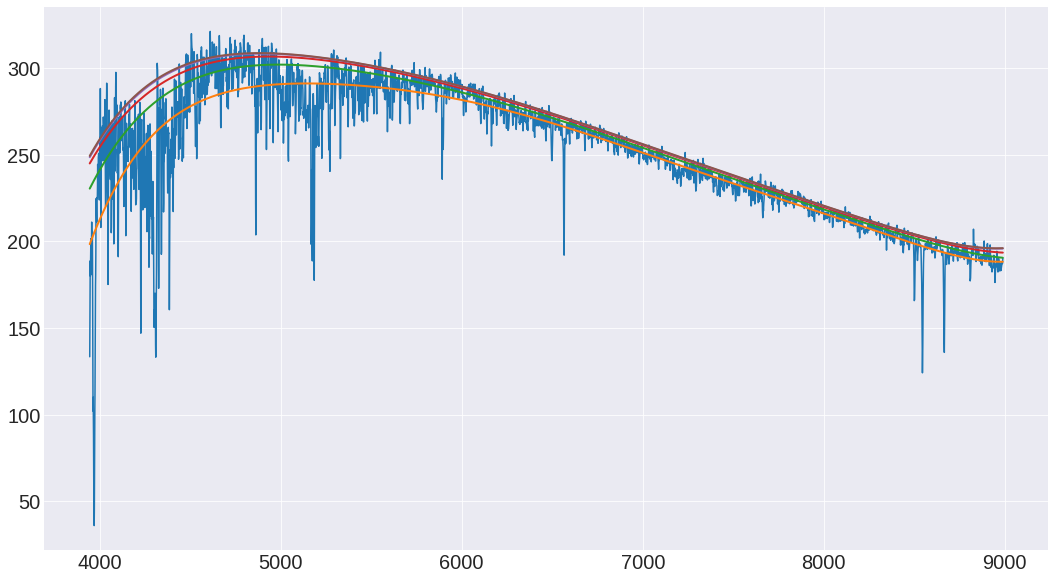

In [17]:
j = 94
deg = 7

plt.figure(figsize=(18,10))
plt.plot(wl, mags[j])

p = np.polyfit(wl, mags[j], deg)
polyfit = Polynomial(wl, p)
plt.plot(wl, polyfit, lw=2)

for i in range(4):
    w = np.ones(nr_pixels)
    w[mags[j] < polyfit] = 0.15
    p = np.polyfit(wl, mags[j], deg, w=w)
    polyfit = Polynomial(wl, p)

    plt.plot(wl, polyfit, lw=2)

In [18]:
def ContinuumFit(wl, mags):
    polyfits = np.zeros((nr_stars, nr_pixels))
    wl1, wl2 = np.split(wl, [2168])
    for j in trange(nr_stars):
        mag1, mag2 = np.split(mags[j], [2168])
        p1 = np.polyfit(wl1, mag1, deg)
        p2 = np.polyfit(wl2, mag2, deg)
        polyfit1 = Polynomial(wl1, p1)
        polyfit2 = Polynomial(wl2, p2)
        for i in range(4):
            w1 = np.ones(len(wl1))
            w2 = np.ones(len(wl2))
            w1[mag1 < polyfit1] = 0.15
            w2[mag2 < polyfit2] = 0.15
            p1 = np.polyfit(wl1, mag1, deg, w=w1)
            p2 = np.polyfit(wl2, mag2, deg, w=w2)
            polyfit1 = Polynomial(wl1, p1)
            polyfit2 = Polynomial(wl2, p2)
        polyfits[j] = np.concatenate((polyfit1, polyfit2), axis=0)
    return polyfits

polyfits = ContinuumFit(wl, mags)
mags_norm_poly = mags/polyfits

100%|██████████| 396/396 [00:03<00:00, 110.34it/s]


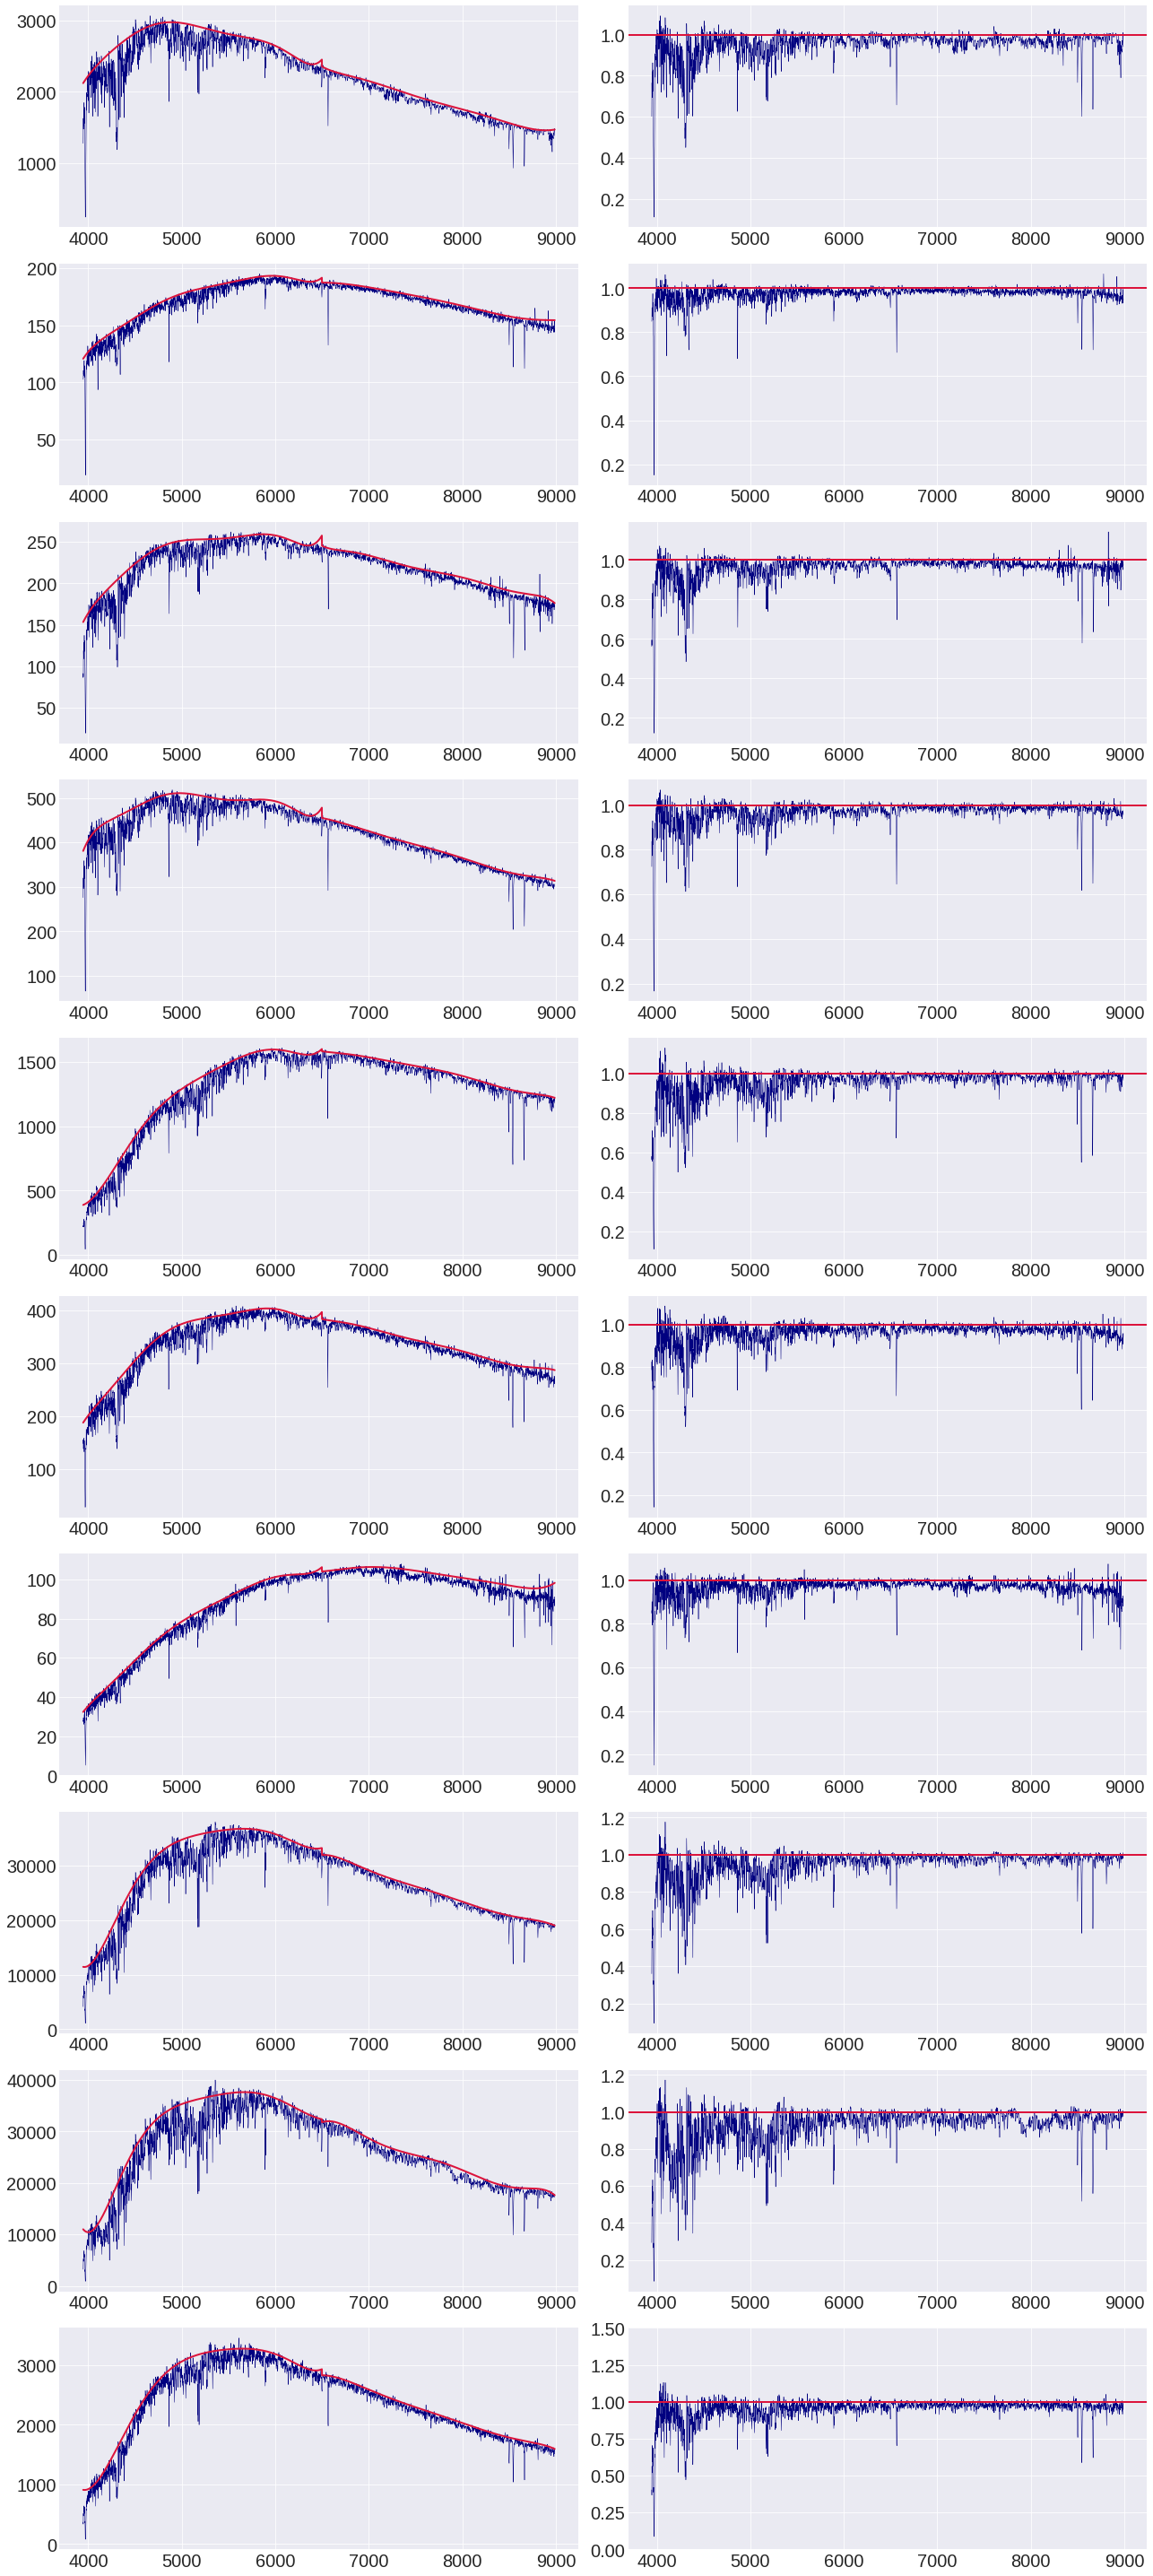

In [19]:
fig, ax = plt.subplots(10, 2, figsize=(18,40)); plt.ylim(0, 1.5)

for i in range(10):
    j = 32*i
    ax[i,0].plot(wl, mags[j], c="navy", lw=0.5)
    ax[i,0].plot(wl, polyfits[j], c="crimson", lw=2)
    ax[i,1].plot(wl, mags_norm_poly[j], c="navy", lw=0.5)
    ax[i,1].axhline(y=1, c="crimson", lw=2)
plt.tight_layout();

### 2.7.2 Training a spectra predicting neural net
Neural networks will be trained and employed using keras, in some combination with sklearn, which is used to scale labels. Below, labels are scaled to zero mean and unit variance. A dense neural net is then trained using the popular Adam optimizer, with two hidden layers of size 36.

We will first train the neural net with a 30% validation split, monitoring loss in both training and validation set. This will allow us to see at approximatly what epoch the network stars overfitting. We can then use this information in our final training of the network, chosing the appropriate number of epochs, and reducing the need for a validaton set in our final fit.

In [20]:
ScalerNN = preprocessing.StandardScaler()
ScalerNN.fit(labels)
input_scaled = ScalerNN.transform(labels)
output = mags_norm_poly.copy()

In [21]:
opti = optimizers.adam(amsgrad=True, lr=0.0003)
def nn_clf():
    model = Sequential()
    model.add(Dense(36, input_shape=(3,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(36,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(nr_pixels, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_absolute_error',  metrics=['mae',"mse"])
    return model
nn_clf().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 36)                1332      
_________________________________________________________________
dense_3 (Dense)              (None, 3577)              132349    
Total params: 133,825
Trainable params: 133,825
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = History()
clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=10000, callbacks=[history], validation_split=0.30, verbose=0)
history = clf.fit(input_scaled, output)

Train on 277 samples, validate on 119 samples
Epoch 1/10000
277/277 [==============================] - 0s 758us/step - loss: 0.9238 - mean_absolute_error: 0.9238 - mean_squared_error: 0.8617 - val_loss: 0.8783 - val_mean_absolute_error: 0.8783 - val_mean_squared_error: 0.7793
Epoch 2/10000
277/277 [==============================] - 0s 155us/step - loss: 0.7682 - mean_absolute_error: 0.7682 - mean_squared_error: 0.6056 - val_loss: 0.5700 - val_mean_absolute_error: 0.5700 - val_mean_squared_error: 0.3347
Epoch 3/10000
277/277 [==============================] - 0s 156us/step - loss: 0.3005 - mean_absolute_error: 0.3005 - mean_squared_error: 0.1245 - val_loss: 0.1367 - val_mean_absolute_error: 0.1367 - val_mean_squared_error: 0.0302
Epoch 4/10000
277/277 [==============================] - 0s 165us/step - loss: 0.0998 - mean_absolute_error: 0.0998 - mean_squared_error: 0.0198 - val_loss: 0.0523 - val_mean_absolute_error: 0.0523 - val_mean_squared_error: 0.0052
Epoch 5/10000
277/277 [=======

277/277 [==============================] - 0s 157us/step - loss: 0.0223 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0025 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 72/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0222 - mean_absolute_error: 0.0222 - mean_squared_error: 0.0025 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 73/10000
277/277 [==============================] - 0s 146us/step - loss: 0.0221 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0025 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 74/10000
277/277 [==============================] - 0s 147us/step - loss: 0.0224 - mean_absolute_error: 0.0224 - mean_squared_error: 0.0025 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 75/10000
277/277 [==============================] - 0s 144us/step - loss: 0.0223 

277/277 [==============================] - 0s 145us/step - loss: 0.0219 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 142/10000
277/277 [==============================] - 0s 152us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 143/10000
277/277 [==============================] - 0s 154us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 144/10000
277/277 [==============================] - 0s 142us/step - loss: 0.0219 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 145/10000
277/277 [==============================] - 0s 140us/step - loss: 0.0

277/277 [==============================] - 0s 136us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 212/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 213/10000
277/277 [==============================] - 0s 146us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 214/10000
277/277 [==============================] - 0s 142us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 215/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0

277/277 [==============================] - 0s 149us/step - loss: 0.0220 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 282/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0219 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 283/10000
277/277 [==============================] - 0s 139us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 284/10000
277/277 [==============================] - 0s 190us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 285/10000
277/277 [==============================] - 0s 157us/step - loss: 0.0

277/277 [==============================] - 0s 170us/step - loss: 0.0220 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 352/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 353/10000
277/277 [==============================] - 0s 185us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 354/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 355/10000
277/277 [==============================] - 0s 159us/step - loss: 0.0

277/277 [==============================] - 0s 135us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 422/10000
277/277 [==============================] - 0s 150us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 423/10000
277/277 [==============================] - 0s 144us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 424/10000
277/277 [==============================] - 0s 140us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0016
Epoch 425/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0

277/277 [==============================] - 0s 153us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 492/10000
277/277 [==============================] - 0s 152us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 0.0016
Epoch 493/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 494/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0016
Epoch 495/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0

277/277 [==============================] - 0s 146us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 562/10000
277/277 [==============================] - 0s 142us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 563/10000
277/277 [==============================] - 0s 137us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 564/10000
277/277 [==============================] - 0s 136us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 565/10000
277/277 [==============================] - 0s 139us/step - loss: 0.0

277/277 [==============================] - 0s 140us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 632/10000
277/277 [==============================] - 0s 142us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 633/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0219 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 634/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 635/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0

277/277 [==============================] - 0s 152us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 702/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 703/10000
277/277 [==============================] - 0s 156us/step - loss: 0.0219 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 704/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 705/10000
277/277 [==============================] - 0s 161us/step - loss: 0.0

277/277 [==============================] - 0s 179us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 772/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 773/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 774/10000
277/277 [==============================] - 0s 168us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 775/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0

277/277 [==============================] - 0s 188us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 842/10000
277/277 [==============================] - 0s 180us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 843/10000
277/277 [==============================] - 0s 168us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 844/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 0.0015
Epoch 845/10000
277/277 [==============================] - 0s 177us/step - loss: 0.0

277/277 [==============================] - 0s 144us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 912/10000
277/277 [==============================] - 0s 170us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 913/10000
277/277 [==============================] - 0s 181us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 914/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 915/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0

277/277 [==============================] - 0s 190us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 982/10000
277/277 [==============================] - 0s 163us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 983/10000
277/277 [==============================] - 0s 156us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 984/10000
277/277 [==============================] - 0s 136us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 985/10000
277/277 [==============================] - 0s 157us/step - loss: 0.0

277/277 [==============================] - 0s 193us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0016
Epoch 1052/10000
277/277 [==============================] - 0s 176us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1053/10000
277/277 [==============================] - 0s 195us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1054/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1055/10000
277/277 [==============================] - 0s 184us/step - loss:

277/277 [==============================] - 0s 206us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1122/10000
277/277 [==============================] - 0s 219us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1123/10000
277/277 [==============================] - 0s 193us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1124/10000
277/277 [==============================] - 0s 201us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1125/10000
277/277 [==============================] - 0s 192us/step - loss:

277/277 [==============================] - 0s 147us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1192/10000
277/277 [==============================] - 0s 147us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 1193/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1194/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0016
Epoch 1195/10000
277/277 [==============================] - 0s 141us/step - loss:

277/277 [==============================] - 0s 187us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1262/10000
277/277 [==============================] - 0s 153us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 1263/10000
277/277 [==============================] - 0s 144us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1264/10000
277/277 [==============================] - 0s 150us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1265/10000
277/277 [==============================] - 0s 150us/step - loss:

277/277 [==============================] - 0s 164us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1332/10000
277/277 [==============================] - 0s 153us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1333/10000
277/277 [==============================] - 0s 157us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1334/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1335/10000
277/277 [==============================] - 0s 166us/step - loss:

277/277 [==============================] - 0s 195us/step - loss: 0.0218 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1402/10000
277/277 [==============================] - 0s 224us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 1403/10000
277/277 [==============================] - 0s 234us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1404/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1405/10000
277/277 [==============================] - 0s 168us/step - loss:

277/277 [==============================] - 0s 205us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1472/10000
277/277 [==============================] - 0s 186us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1473/10000
277/277 [==============================] - 0s 185us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1474/10000
277/277 [==============================] - 0s 186us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1475/10000
277/277 [==============================] - 0s 170us/step - loss:

277/277 [==============================] - 0s 195us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 1542/10000
277/277 [==============================] - 0s 202us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 1543/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 1544/10000
277/277 [==============================] - 0s 160us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1545/10000
277/277 [==============================] - 0s 174us/step - loss:

277/277 [==============================] - 0s 189us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1612/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 1613/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1614/10000
277/277 [==============================] - 0s 186us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1615/10000
277/277 [==============================] - 0s 179us/step - loss:

277/277 [==============================] - 0s 1ms/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 1682/10000
277/277 [==============================] - 0s 884us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1683/10000
277/277 [==============================] - 0s 819us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0016
Epoch 1684/10000
277/277 [==============================] - 0s 769us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1685/10000
277/277 [==============================] - 0s 765us/step - loss: 0

277/277 [==============================] - 0s 429us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1752/10000
277/277 [==============================] - 0s 422us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1753/10000
277/277 [==============================] - 0s 418us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1754/10000
277/277 [==============================] - 0s 397us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 1755/10000
277/277 [==============================] - 0s 387us/step - loss:

277/277 [==============================] - 0s 341us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1822/10000
277/277 [==============================] - 0s 312us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1823/10000
277/277 [==============================] - 0s 338us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 1824/10000
277/277 [==============================] - 0s 319us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1825/10000
277/277 [==============================] - 0s 314us/step - loss:

277/277 [==============================] - 0s 261us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1892/10000
277/277 [==============================] - 0s 261us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1893/10000
277/277 [==============================] - 0s 286us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1894/10000
277/277 [==============================] - 0s 293us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1895/10000
277/277 [==============================] - 0s 317us/step - loss:

277/277 [==============================] - 0s 334us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 1962/10000
277/277 [==============================] - 0s 338us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 1963/10000
277/277 [==============================] - 0s 306us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 1964/10000
277/277 [==============================] - 0s 299us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 1965/10000
277/277 [==============================] - 0s 327us/step - loss:

277/277 [==============================] - 0s 252us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2032/10000
277/277 [==============================] - 0s 298us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 2033/10000
277/277 [==============================] - 0s 247us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2034/10000
277/277 [==============================] - 0s 233us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2035/10000
277/277 [==============================] - 0s 227us/step - loss:

277/277 [==============================] - 0s 193us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2102/10000
277/277 [==============================] - 0s 206us/step - loss: 0.0217 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2103/10000
277/277 [==============================] - 0s 209us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2104/10000
277/277 [==============================] - 0s 199us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0016
Epoch 2105/10000
277/277 [==============================] - 0s 216us/step - loss:

277/277 [==============================] - 0s 213us/step - loss: 0.0215 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2172/10000
277/277 [==============================] - 0s 221us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0233 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0016
Epoch 2173/10000
277/277 [==============================] - 0s 193us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2174/10000
277/277 [==============================] - 0s 215us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2175/10000
277/277 [==============================] - 0s 199us/step - loss:

277/277 [==============================] - 0s 202us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2242/10000
277/277 [==============================] - 0s 194us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2243/10000
277/277 [==============================] - 0s 180us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2244/10000
277/277 [==============================] - 0s 192us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2245/10000
277/277 [==============================] - 0s 170us/step - loss:

277/277 [==============================] - 0s 184us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2312/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2313/10000
277/277 [==============================] - 0s 167us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2314/10000
277/277 [==============================] - 0s 166us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0016
Epoch 2315/10000
277/277 [==============================] - 0s 162us/step - loss:

277/277 [==============================] - 0s 202us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2382/10000
277/277 [==============================] - 0s 193us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2383/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 2384/10000
277/277 [==============================] - 0s 183us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2385/10000
277/277 [==============================] - 0s 182us/step - loss:

277/277 [==============================] - 0s 161us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2452/10000
277/277 [==============================] - 0s 169us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2453/10000
277/277 [==============================] - 0s 165us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2454/10000
277/277 [==============================] - 0s 163us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2455/10000
277/277 [==============================] - 0s 163us/step - loss:

277/277 [==============================] - 0s 174us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2522/10000
277/277 [==============================] - 0s 181us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2523/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2524/10000
277/277 [==============================] - 0s 180us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2525/10000
277/277 [==============================] - 0s 202us/step - loss:

277/277 [==============================] - 0s 161us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 2592/10000
277/277 [==============================] - 0s 168us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2593/10000
277/277 [==============================] - 0s 167us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2594/10000
277/277 [==============================] - 0s 170us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2595/10000
277/277 [==============================] - 0s 191us/step - loss:

277/277 [==============================] - 0s 220us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2662/10000
277/277 [==============================] - 0s 244us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2663/10000
277/277 [==============================] - 0s 276us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2664/10000
277/277 [==============================] - 0s 287us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2665/10000
277/277 [==============================] - 0s 269us/step - loss:

277/277 [==============================] - 0s 206us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 2732/10000
277/277 [==============================] - 0s 192us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2733/10000
277/277 [==============================] - 0s 188us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2734/10000
277/277 [==============================] - 0s 245us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2735/10000
277/277 [==============================] - 0s 189us/step - loss:

277/277 [==============================] - 0s 180us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2802/10000
277/277 [==============================] - 0s 173us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2803/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2804/10000
277/277 [==============================] - 0s 161us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2805/10000
277/277 [==============================] - 0s 185us/step - loss:

277/277 [==============================] - 0s 201us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0235 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0016
Epoch 2872/10000
277/277 [==============================] - 0s 201us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 2873/10000
277/277 [==============================] - 0s 224us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 2874/10000
277/277 [==============================] - 0s 186us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 2875/10000
277/277 [==============================] - 0s 211us/step - loss:

277/277 [==============================] - 0s 184us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 2942/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 2943/10000
277/277 [==============================] - 0s 212us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 2944/10000
277/277 [==============================] - 0s 212us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 2945/10000
277/277 [==============================] - 0s 195us/step - loss:

277/277 [==============================] - 0s 162us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3012/10000
277/277 [==============================] - 0s 155us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 3013/10000
277/277 [==============================] - 0s 144us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0016
Epoch 3014/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3015/10000
277/277 [==============================] - 0s 133us/step - loss:

277/277 [==============================] - 0s 139us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3082/10000
277/277 [==============================] - 0s 156us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3083/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0016
Epoch 3084/10000
277/277 [==============================] - 0s 137us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 3085/10000
277/277 [==============================] - 0s 149us/step - loss:

277/277 [==============================] - 0s 142us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3152/10000
277/277 [==============================] - 0s 154us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3153/10000
277/277 [==============================] - 0s 160us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 3154/10000
277/277 [==============================] - 0s 146us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3155/10000
277/277 [==============================] - 0s 155us/step - loss:

277/277 [==============================] - 0s 165us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0236 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0016
Epoch 3222/10000
277/277 [==============================] - 0s 177us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3223/10000
277/277 [==============================] - 0s 160us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 3224/10000
277/277 [==============================] - 0s 149us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0016
Epoch 3225/10000
277/277 [==============================] - 0s 162us/step - loss:

277/277 [==============================] - 0s 215us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3292/10000
277/277 [==============================] - 0s 280us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3293/10000
277/277 [==============================] - 0s 199us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3294/10000
277/277 [==============================] - 0s 195us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3295/10000
277/277 [==============================] - 0s 176us/step - loss:

277/277 [==============================] - 0s 212us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3362/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 3363/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245 - val_mean_squared_error: 0.0016
Epoch 3364/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 3365/10000
277/277 [==============================] - 0s 187us/step - loss:

277/277 [==============================] - 0s 164us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3432/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0016
Epoch 3433/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3434/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3435/10000
277/277 [==============================] - 0s 159us/step - loss:

277/277 [==============================] - 0s 177us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3502/10000
277/277 [==============================] - 0s 157us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3503/10000
277/277 [==============================] - 0s 150us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3504/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3505/10000
277/277 [==============================] - 0s 161us/step - loss:

277/277 [==============================] - 0s 198us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3572/10000
277/277 [==============================] - 0s 194us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 3573/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 3574/10000
277/277 [==============================] - 0s 185us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 3575/10000
277/277 [==============================] - 0s 184us/step - loss:

277/277 [==============================] - 0s 172us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3642/10000
277/277 [==============================] - 0s 179us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 3643/10000
277/277 [==============================] - 0s 172us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3644/10000
277/277 [==============================] - 0s 177us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3645/10000
277/277 [==============================] - 0s 188us/step - loss:

277/277 [==============================] - 0s 220us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3712/10000
277/277 [==============================] - 0s 201us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3713/10000
277/277 [==============================] - 0s 186us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3714/10000
277/277 [==============================] - 0s 190us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3715/10000
277/277 [==============================] - 0s 248us/step - loss:

277/277 [==============================] - 0s 190us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3782/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 3783/10000
277/277 [==============================] - 0s 166us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3784/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3785/10000
277/277 [==============================] - 0s 146us/step - loss:

277/277 [==============================] - 0s 207us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3852/10000
277/277 [==============================] - 0s 191us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3853/10000
277/277 [==============================] - 0s 194us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0016
Epoch 3854/10000
277/277 [==============================] - 0s 207us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 3855/10000
277/277 [==============================] - 0s 193us/step - loss:

277/277 [==============================] - 0s 171us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0016
Epoch 3922/10000
277/277 [==============================] - 0s 176us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3923/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 3924/10000
277/277 [==============================] - 0s 183us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3925/10000
277/277 [==============================] - 0s 164us/step - loss:

277/277 [==============================] - 0s 170us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 3992/10000
277/277 [==============================] - 0s 191us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 3993/10000
277/277 [==============================] - 0s 162us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3994/10000
277/277 [==============================] - 0s 173us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 3995/10000
277/277 [==============================] - 0s 186us/step - loss:

277/277 [==============================] - 0s 162us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4062/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 4063/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4064/10000
277/277 [==============================] - 0s 176us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 4065/10000
277/277 [==============================] - 0s 178us/step - loss:

277/277 [==============================] - 0s 175us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245 - val_mean_squared_error: 0.0017
Epoch 4132/10000
277/277 [==============================] - 0s 179us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4133/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4134/10000
277/277 [==============================] - 0s 167us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 4135/10000
277/277 [==============================] - 0s 156us/step - loss:

277/277 [==============================] - 0s 231us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4202/10000
277/277 [==============================] - 0s 260us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 4203/10000
277/277 [==============================] - 0s 203us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 4204/10000
277/277 [==============================] - 0s 193us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 4205/10000
277/277 [==============================] - 0s 210us/step - loss:

277/277 [==============================] - 0s 177us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4272/10000
277/277 [==============================] - 0s 177us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 4273/10000
277/277 [==============================] - 0s 175us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4274/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4275/10000
277/277 [==============================] - 0s 178us/step - loss:

277/277 [==============================] - 0s 171us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4342/10000
277/277 [==============================] - 0s 174us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4343/10000
277/277 [==============================] - 0s 170us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246 - val_mean_squared_error: 0.0017
Epoch 4344/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4345/10000
277/277 [==============================] - 0s 152us/step - loss:

277/277 [==============================] - 0s 162us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 4412/10000
277/277 [==============================] - 0s 174us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0016
Epoch 4413/10000
277/277 [==============================] - 0s 172us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 4414/10000
277/277 [==============================] - 0s 178us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 4415/10000
277/277 [==============================] - 0s 170us/step - loss:

277/277 [==============================] - 0s 164us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 4482/10000
277/277 [==============================] - 0s 161us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4483/10000
277/277 [==============================] - 0s 161us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4484/10000
277/277 [==============================] - 0s 158us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 4485/10000
277/277 [==============================] - 0s 187us/step - loss:

277/277 [==============================] - 0s 180us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4552/10000
277/277 [==============================] - 0s 181us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4553/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4554/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4555/10000
277/277 [==============================] - 0s 173us/step - loss:

277/277 [==============================] - 0s 152us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4622/10000
277/277 [==============================] - 0s 175us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 4623/10000
277/277 [==============================] - 0s 170us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 4624/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 4625/10000
277/277 [==============================] - 0s 181us/step - loss:

277/277 [==============================] - 0s 170us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 4692/10000
277/277 [==============================] - 0s 192us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 4693/10000
277/277 [==============================] - 0s 155us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 4694/10000
277/277 [==============================] - 0s 156us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4695/10000
277/277 [==============================] - 0s 169us/step - loss:

277/277 [==============================] - 0s 172us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4762/10000
277/277 [==============================] - 0s 195us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4763/10000
277/277 [==============================] - 0s 177us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4764/10000
277/277 [==============================] - 0s 190us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4765/10000
277/277 [==============================] - 0s 185us/step - loss:

277/277 [==============================] - 0s 174us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 4832/10000
277/277 [==============================] - 0s 183us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 4833/10000
277/277 [==============================] - 0s 215us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4834/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4835/10000
277/277 [==============================] - 0s 193us/step - loss:

277/277 [==============================] - 0s 181us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 4902/10000
277/277 [==============================] - 0s 179us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 4903/10000
277/277 [==============================] - 0s 159us/step - loss: 0.0214 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 4904/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 4905/10000
277/277 [==============================] - 0s 193us/step - loss:

277/277 [==============================] - 0s 174us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 4972/10000
277/277 [==============================] - 0s 180us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 4973/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 4974/10000
277/277 [==============================] - 0s 261us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 4975/10000
277/277 [==============================] - 0s 216us/step - loss:

277/277 [==============================] - 0s 201us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5042/10000
277/277 [==============================] - 0s 216us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5043/10000
277/277 [==============================] - 0s 199us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 5044/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 5045/10000
277/277 [==============================] - 0s 176us/step - loss:

277/277 [==============================] - 0s 202us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5112/10000
277/277 [==============================] - 0s 206us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 5113/10000
277/277 [==============================] - 0s 194us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5114/10000
277/277 [==============================] - 0s 234us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5115/10000
277/277 [==============================] - 0s 186us/step - loss:

277/277 [==============================] - 0s 198us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 5182/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5183/10000
277/277 [==============================] - 0s 202us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5184/10000
277/277 [==============================] - 0s 192us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5185/10000
277/277 [==============================] - 0s 190us/step - loss:

277/277 [==============================] - 0s 205us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 5252/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5253/10000
277/277 [==============================] - 0s 180us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5254/10000
277/277 [==============================] - 0s 168us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5255/10000
277/277 [==============================] - 0s 162us/step - loss:

277/277 [==============================] - 0s 171us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5322/10000
277/277 [==============================] - 0s 176us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5323/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 5324/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 5325/10000
277/277 [==============================] - 0s 177us/step - loss:

277/277 [==============================] - 0s 151us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 5392/10000
277/277 [==============================] - 0s 179us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5393/10000
277/277 [==============================] - 0s 169us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 5394/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5395/10000
277/277 [==============================] - 0s 191us/step - loss:

277/277 [==============================] - 0s 165us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5462/10000
277/277 [==============================] - 0s 199us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 5463/10000
277/277 [==============================] - 0s 170us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5464/10000
277/277 [==============================] - 0s 163us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 5465/10000
277/277 [==============================] - 0s 217us/step - loss:

277/277 [==============================] - 0s 190us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5532/10000
277/277 [==============================] - 0s 186us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 5533/10000
277/277 [==============================] - 0s 166us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 5534/10000
277/277 [==============================] - 0s 176us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 5535/10000
277/277 [==============================] - 0s 174us/step - loss:

277/277 [==============================] - 0s 166us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 5602/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5603/10000
277/277 [==============================] - 0s 163us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5604/10000
277/277 [==============================] - 0s 158us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5605/10000
277/277 [==============================] - 0s 198us/step - loss:

277/277 [==============================] - 0s 164us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5672/10000
277/277 [==============================] - 0s 183us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 5673/10000
277/277 [==============================] - 0s 198us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5674/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5675/10000
277/277 [==============================] - 0s 151us/step - loss:

277/277 [==============================] - 0s 208us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 5742/10000
277/277 [==============================] - 0s 188us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5743/10000
277/277 [==============================] - 0s 164us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5744/10000
277/277 [==============================] - 0s 155us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5745/10000
277/277 [==============================] - 0s 167us/step - loss:

277/277 [==============================] - 0s 213us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5812/10000
277/277 [==============================] - 0s 213us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5813/10000
277/277 [==============================] - 0s 211us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5814/10000
277/277 [==============================] - 0s 221us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5815/10000
277/277 [==============================] - 0s 214us/step - loss:

277/277 [==============================] - 0s 224us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 5882/10000
277/277 [==============================] - 0s 203us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 5883/10000
277/277 [==============================] - 0s 193us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5884/10000
277/277 [==============================] - 0s 211us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5885/10000
277/277 [==============================] - 0s 187us/step - loss:

277/277 [==============================] - 0s 204us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5952/10000
277/277 [==============================] - 0s 192us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 5953/10000
277/277 [==============================] - 0s 189us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 5954/10000
277/277 [==============================] - 0s 183us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 5955/10000
277/277 [==============================] - 0s 208us/step - loss:

277/277 [==============================] - 0s 168us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6022/10000
277/277 [==============================] - 0s 188us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6023/10000
277/277 [==============================] - 0s 172us/step - loss: 0.0213 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 6024/10000
277/277 [==============================] - 0s 168us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6025/10000
277/277 [==============================] - 0s 193us/step - loss:

277/277 [==============================] - 0s 175us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 6092/10000
277/277 [==============================] - 0s 179us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 6093/10000
277/277 [==============================] - 0s 168us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 6094/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6095/10000
277/277 [==============================] - 0s 158us/step - loss:

277/277 [==============================] - 0s 204us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 6162/10000
277/277 [==============================] - 0s 221us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6163/10000
277/277 [==============================] - 0s 217us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6164/10000
277/277 [==============================] - 0s 204us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6165/10000
277/277 [==============================] - 0s 210us/step - loss:

277/277 [==============================] - 0s 146us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245 - val_mean_squared_error: 0.0017
Epoch 6232/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6233/10000
277/277 [==============================] - 0s 152us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6234/10000
277/277 [==============================] - 0s 200us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 6235/10000
277/277 [==============================] - 0s 189us/step - loss:

277/277 [==============================] - 0s 159us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6302/10000
277/277 [==============================] - 0s 153us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6303/10000
277/277 [==============================] - 0s 148us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6304/10000
277/277 [==============================] - 0s 162us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6305/10000
277/277 [==============================] - 0s 164us/step - loss:

277/277 [==============================] - 0s 156us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 6372/10000
277/277 [==============================] - 0s 153us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6373/10000
277/277 [==============================] - 0s 156us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 6374/10000
277/277 [==============================] - 0s 141us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 6375/10000
277/277 [==============================] - 0s 166us/step - loss:

277/277 [==============================] - 0s 180us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6442/10000
277/277 [==============================] - 0s 210us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6443/10000
277/277 [==============================] - 0s 187us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 6444/10000
277/277 [==============================] - 0s 273us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6445/10000
277/277 [==============================] - 0s 212us/step - loss:

277/277 [==============================] - 0s 157us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6512/10000
277/277 [==============================] - 0s 160us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6513/10000
277/277 [==============================] - 0s 158us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6514/10000
277/277 [==============================] - 0s 158us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 6515/10000
277/277 [==============================] - 0s 160us/step - loss:

277/277 [==============================] - 0s 184us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6582/10000
277/277 [==============================] - 0s 182us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 6583/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6584/10000
277/277 [==============================] - 0s 198us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 6585/10000
277/277 [==============================] - 0s 182us/step - loss:

277/277 [==============================] - 0s 155us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 6652/10000
277/277 [==============================] - 0s 173us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6653/10000
277/277 [==============================] - 0s 178us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6654/10000
277/277 [==============================] - 0s 167us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 6655/10000
277/277 [==============================] - 0s 168us/step - loss:

277/277 [==============================] - 0s 186us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 6722/10000
277/277 [==============================] - 0s 185us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 6723/10000
277/277 [==============================] - 0s 171us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 6724/10000
277/277 [==============================] - 0s 162us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6725/10000
277/277 [==============================] - 0s 187us/step - loss:

277/277 [==============================] - 0s 188us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6792/10000
277/277 [==============================] - 0s 173us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6793/10000
277/277 [==============================] - 0s 174us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 6794/10000
277/277 [==============================] - 0s 165us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 6795/10000
277/277 [==============================] - 0s 174us/step - loss:

277/277 [==============================] - 0s 151us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6862/10000
277/277 [==============================] - 0s 161us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6863/10000
277/277 [==============================] - 0s 174us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 6864/10000
277/277 [==============================] - 0s 193us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 6865/10000
277/277 [==============================] - 0s 215us/step - loss:

277/277 [==============================] - 0s 214us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 6932/10000
277/277 [==============================] - 0s 184us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 6933/10000
277/277 [==============================] - 0s 163us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 6934/10000
277/277 [==============================] - 0s 188us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 6935/10000
277/277 [==============================] - 0s 175us/step - loss:

277/277 [==============================] - 0s 131us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7002/10000
277/277 [==============================] - 0s 131us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 7003/10000
277/277 [==============================] - 0s 137us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7004/10000
277/277 [==============================] - 0s 174us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7005/10000
277/277 [==============================] - 0s 147us/step - loss:

277/277 [==============================] - 0s 196us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 7072/10000
277/277 [==============================] - 0s 149us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 0.0016
Epoch 7073/10000
277/277 [==============================] - 0s 162us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7074/10000
277/277 [==============================] - 0s 209us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7075/10000
277/277 [==============================] - 0s 193us/step - loss:

277/277 [==============================] - 0s 185us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7142/10000
277/277 [==============================] - 0s 196us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 7143/10000
277/277 [==============================] - 0s 167us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 7144/10000
277/277 [==============================] - 0s 156us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7145/10000
277/277 [==============================] - 0s 157us/step - loss:

277/277 [==============================] - 0s 154us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7212/10000
277/277 [==============================] - 0s 150us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 7213/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7214/10000
277/277 [==============================] - 0s 136us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7215/10000
277/277 [==============================] - 0s 137us/step - loss:

277/277 [==============================] - 0s 141us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 7282/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7283/10000
277/277 [==============================] - 0s 141us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 7284/10000
277/277 [==============================] - 0s 137us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7285/10000
277/277 [==============================] - 0s 140us/step - loss:

277/277 [==============================] - 0s 186us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7352/10000
277/277 [==============================] - 0s 152us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7353/10000
277/277 [==============================] - 0s 146us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7354/10000
277/277 [==============================] - 0s 144us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 7355/10000
277/277 [==============================] - 0s 149us/step - loss:

277/277 [==============================] - 0s 150us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7422/10000
277/277 [==============================] - 0s 149us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 7423/10000
277/277 [==============================] - 0s 157us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7424/10000
277/277 [==============================] - 0s 150us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7425/10000
277/277 [==============================] - 0s 162us/step - loss:

277/277 [==============================] - 0s 154us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7492/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7493/10000
277/277 [==============================] - 0s 145us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 7494/10000
277/277 [==============================] - 0s 167us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7495/10000
277/277 [==============================] - 0s 202us/step - loss:

277/277 [==============================] - 0s 150us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7562/10000
277/277 [==============================] - 0s 154us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7563/10000
277/277 [==============================] - 0s 162us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7564/10000
277/277 [==============================] - 0s 154us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 7565/10000
277/277 [==============================] - 0s 149us/step - loss:

277/277 [==============================] - 0s 147us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 7632/10000
277/277 [==============================] - 0s 160us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 7633/10000
277/277 [==============================] - 0s 255us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 7634/10000
277/277 [==============================] - 0s 153us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 7635/10000
277/277 [==============================] - 0s 152us/step - loss:

277/277 [==============================] - 0s 138us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7702/10000
277/277 [==============================] - 0s 131us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 7703/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7704/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 7705/10000
277/277 [==============================] - 0s 130us/step - loss:

277/277 [==============================] - 0s 136us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 7772/10000
277/277 [==============================] - 0s 128us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7773/10000
277/277 [==============================] - 0s 135us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 7774/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 7775/10000
277/277 [==============================] - 0s 135us/step - loss:

277/277 [==============================] - 0s 138us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7842/10000
277/277 [==============================] - 0s 135us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 7843/10000
277/277 [==============================] - 0s 140us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7844/10000
277/277 [==============================] - 0s 151us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7845/10000
277/277 [==============================] - 0s 148us/step - loss:

277/277 [==============================] - 0s 137us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7912/10000
277/277 [==============================] - 0s 125us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7913/10000
277/277 [==============================] - 0s 128us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7914/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7915/10000
277/277 [==============================] - 0s 124us/step - loss:

277/277 [==============================] - 0s 133us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 7982/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 7983/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0016
Epoch 7984/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 7985/10000
277/277 [==============================] - 0s 131us/step - loss:

277/277 [==============================] - 0s 133us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 8052/10000
277/277 [==============================] - 0s 131us/step - loss: 0.0212 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8053/10000
277/277 [==============================] - 0s 131us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8054/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 8055/10000
277/277 [==============================] - 0s 134us/step - loss:

277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8122/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 8123/10000
277/277 [==============================] - 0s 129us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 8124/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0016
Epoch 8125/10000
277/277 [==============================] - 0s 130us/step - loss:

277/277 [==============================] - 0s 129us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8192/10000
277/277 [==============================] - 0s 135us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8193/10000
277/277 [==============================] - 0s 129us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 8194/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8195/10000
277/277 [==============================] - 0s 135us/step - loss:

277/277 [==============================] - 0s 125us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 8262/10000
277/277 [==============================] - 0s 127us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8263/10000
277/277 [==============================] - 0s 125us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 8264/10000
277/277 [==============================] - 0s 125us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8265/10000
277/277 [==============================] - 0s 125us/step - loss:

277/277 [==============================] - 0s 127us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8332/10000
277/277 [==============================] - 0s 123us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8333/10000
277/277 [==============================] - 0s 127us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8334/10000
277/277 [==============================] - 0s 124us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8335/10000
277/277 [==============================] - 0s 129us/step - loss:

277/277 [==============================] - 0s 126us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0016
Epoch 8402/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8403/10000
277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 8404/10000
277/277 [==============================] - 0s 127us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 8405/10000
277/277 [==============================] - 0s 126us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8472/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8473/10000
277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8474/10000
277/277 [==============================] - 0s 124us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8475/10000
277/277 [==============================] - 0s 126us/step - loss:

277/277 [==============================] - 0s 134us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8542/10000
277/277 [==============================] - 0s 135us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 8543/10000
277/277 [==============================] - 0s 137us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 8544/10000
277/277 [==============================] - 0s 137us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8545/10000
277/277 [==============================] - 0s 136us/step - loss:

277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8612/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8613/10000
277/277 [==============================] - 0s 135us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0017
Epoch 8614/10000
277/277 [==============================] - 0s 139us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8615/10000
277/277 [==============================] - 0s 139us/step - loss:

277/277 [==============================] - 0s 141us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8682/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8683/10000
277/277 [==============================] - 0s 135us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8684/10000
277/277 [==============================] - 0s 136us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8685/10000
277/277 [==============================] - 0s 133us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8752/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8753/10000
277/277 [==============================] - 0s 123us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8754/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8755/10000
277/277 [==============================] - 0s 126us/step - loss:

277/277 [==============================] - 0s 132us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8822/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8823/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 8824/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8825/10000
277/277 [==============================] - 0s 130us/step - loss:

277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8892/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8893/10000
277/277 [==============================] - 0s 129us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8894/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 8895/10000
277/277 [==============================] - 0s 129us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 8962/10000
277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8963/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 8964/10000
277/277 [==============================] - 0s 125us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 8965/10000
277/277 [==============================] - 0s 124us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9032/10000
277/277 [==============================] - 0s 162us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9033/10000
277/277 [==============================] - 0s 158us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9034/10000
277/277 [==============================] - 0s 146us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9035/10000
277/277 [==============================] - 0s 133us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9102/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9103/10000
277/277 [==============================] - 0s 129us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9104/10000
277/277 [==============================] - 0s 125us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9105/10000
277/277 [==============================] - 0s 124us/step - loss:

277/277 [==============================] - 0s 125us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9172/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9173/10000
277/277 [==============================] - 0s 128us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9174/10000
277/277 [==============================] - 0s 123us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9175/10000
277/277 [==============================] - 0s 126us/step - loss:

277/277 [==============================] - 0s 125us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9242/10000
277/277 [==============================] - 0s 123us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9243/10000
277/277 [==============================] - 0s 126us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9244/10000
277/277 [==============================] - 0s 127us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9245/10000
277/277 [==============================] - 0s 126us/step - loss:

277/277 [==============================] - 0s 131us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9312/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9313/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9314/10000
277/277 [==============================] - 0s 142us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9315/10000
277/277 [==============================] - 0s 130us/step - loss:

277/277 [==============================] - 0s 131us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9382/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9383/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9384/10000
277/277 [==============================] - 0s 131us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9385/10000
277/277 [==============================] - 0s 130us/step - loss:

277/277 [==============================] - 0s 136us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9452/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9453/10000
277/277 [==============================] - 0s 128us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9454/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9455/10000
277/277 [==============================] - 0s 129us/step - loss:

277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9522/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9523/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9524/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9525/10000
277/277 [==============================] - 0s 130us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9592/10000
277/277 [==============================] - 0s 125us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9593/10000
277/277 [==============================] - 0s 127us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9594/10000
277/277 [==============================] - 0s 124us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9595/10000
277/277 [==============================] - 0s 127us/step - loss:

277/277 [==============================] - 0s 132us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9662/10000
277/277 [==============================] - 0s 129us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9663/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9664/10000
277/277 [==============================] - 0s 138us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9665/10000
277/277 [==============================] - 0s 127us/step - loss:

277/277 [==============================] - 0s 131us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0243 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0017
Epoch 9732/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 0.0016
Epoch 9733/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9734/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9735/10000
277/277 [==============================] - 0s 129us/step - loss:

277/277 [==============================] - 0s 137us/step - loss: 0.0211 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9802/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0016
Epoch 9803/10000
277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9804/10000
277/277 [==============================] - 0s 136us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9805/10000
277/277 [==============================] - 0s 134us/step - loss:

277/277 [==============================] - 0s 132us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9872/10000
277/277 [==============================] - 0s 134us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0244 - val_mean_absolute_error: 0.0244 - val_mean_squared_error: 0.0017
Epoch 9873/10000
277/277 [==============================] - 0s 130us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9874/10000
277/277 [==============================] - 0s 133us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9875/10000
277/277 [==============================] - 0s 131us/step - loss:

277/277 [==============================] - 0s 124us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0240 - val_mean_absolute_error: 0.0240 - val_mean_squared_error: 0.0017
Epoch 9942/10000
277/277 [==============================] - 0s 127us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9943/10000
277/277 [==============================] - 0s 122us/step - loss: 0.0209 - mean_absolute_error: 0.0209 - mean_squared_error: 0.0024 - val_loss: 0.0241 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0017
Epoch 9944/10000
277/277 [==============================] - 0s 122us/step - loss: 0.0210 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0024 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242 - val_mean_squared_error: 0.0017
Epoch 9945/10000
277/277 [==============================] - 0s 127us/step - loss:

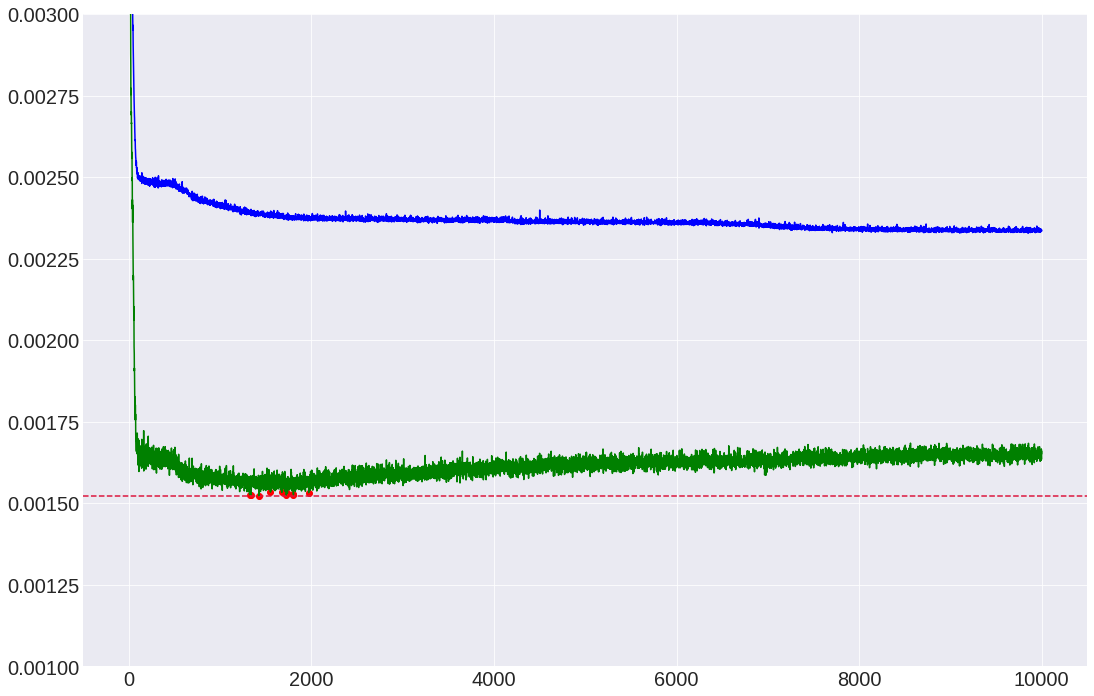

In [40]:
plt.figure(figsize=(18,12))
MSE = np.array(history.history['mean_squared_error'])
val_MSE = np.array(history.history['val_mean_squared_error'])
plt.ylim(0.001, 0.003)
asdf = np.argsort(val_MSE)[:10]
plt.axhline(y=val_MSE[asdf[0]], c="crimson", ls="--")
plt.plot(MSE, c="b")
plt.plot(val_MSE, c="g")
plt.scatter(asdf, val_MSE[asdf], c="r")

In the plot above we show the loss of the training data (blue) and validation data(green). The ten lowest validation loss points are colored in red. From this, we see that the network stars overfitting at around 1200-2000 epochs. We will now train our actual network for 1800 epochs.

In [22]:
clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=1800, verbose=0)
history = clf.fit(input_scaled, output)

Instructions for updating:
Use tf.cast instead.


### 2.7.3 Setting up a label-span to estimate least volatile points
Now, we will make a meshgrid of a representative labels from our label space. These labels will then be put through the network, to predict spectra. Looking at one pixel at the time, the standard diviation of that pixel value along all predicted spectra is found. This is assumed to be a good indicator of how good of an continuums pixel that pixel is. These results are plotted below, together with the chosen continuum pixels.

In [23]:
label_list = [[T, L, F] for T in np.linspace(4600, 5000, 40) for L in np.linspace(1.5, 3, 40) for F in np.linspace(-1.8, 0, 40)]
label_list = np.array(label_list)
label_list_scaled = ScalerNN.transform(label_list)

predicted_spectra = clf.predict(label_list_scaled)

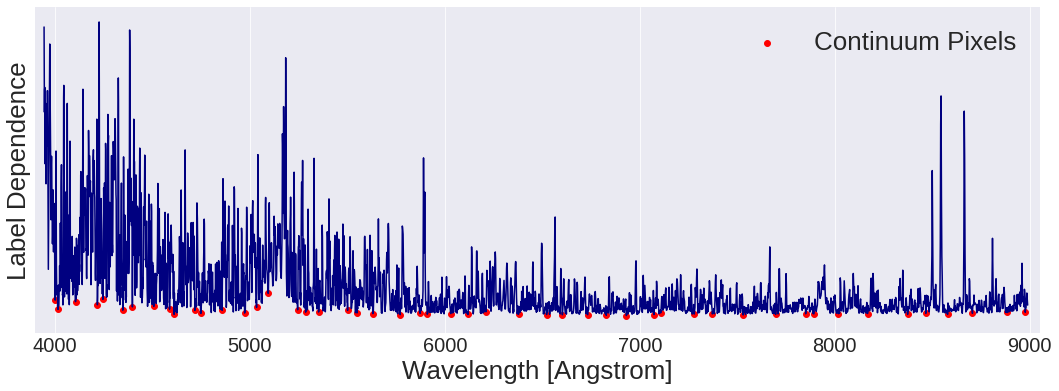

In [24]:
predicted_spectra_std = np.percentile(predicted_spectra, 84, axis=0) - np.percentile(predicted_spectra, 16, axis=0)#np.std(predicted_spectra, axis=0)
plt.figure(figsize=(18,6)); plt.xlim(3900, 9050)
plt.plot(wl, predicted_spectra_std, c="navy")
factor = 3577//49
continuum_idxs = []
for i in range(49):
    minargs = np.argsort(predicted_spectra_std[i*factor:(i+1)*factor])[:1] + i*factor
    minargs = minargs[predicted_spectra_std[minargs] < 0.02]
    continuum_idxs.extend(minargs)
continuum_idxs.extend( np.argsort(predicted_spectra_std[-15:])[:1] + 49*factor - 15)
continuum_idxs = np.array(continuum_idxs)
plt.scatter(wl[continuum_idxs], predicted_spectra_std[continuum_idxs], c="r", s=35, label="Continuum Pixels")
plt.ylabel("Label Dependence", fontsize=26)
plt.xlabel("Wavelength [Angstrom]", fontsize=26)
plt.legend(fontsize=26)
plt.yticks([],[]);

### 2.7.4 Pseudo-Normalization, Round 2!
Now that we have identified pixels most unaffected by label change, we use only these to fit new polynomials, using the same technique as earlier. 

In [25]:
def ContinuumFit2(wl, mags, continuum_idxs):
    wl_cont = wl.copy()[continuum_idxs]
    mags_cont = mags.copy()[continuum_idxs]
    nr_cont_pixels = continuum_idxs.shape[0]
    split_idx = np.argmin(np.abs(wl[continuum_idxs] - 6500))
    polyfits = np.zeros((nr_stars, nr_cont_pixels))
    wl1, wl2 = np.split(wl, [2168])
    wl1_cont, wl2_cont = np.split(wl_cont, [split_idx])
    for j in trange(nr_stars):
        mag1, mag2 = np.split(mags_cont[j], [split_idx])
        p1 = np.polyfit(wl1_cont, mag1_cont, deg)
        p2 = np.polyfit(wl2_cont, mag2_cont, deg)
        polyfit1 = Polynomial(wl1, p1)
        polyfit2 = Polynomial(wl2, p2)
        for i in range(4):
            w1 = np.ones(len(wl1))
            w2 = np.ones(len(wl2))
            w1[mag1 < polyfit1] = 0.15
            w2[mag2 < polyfit2] = 0.15
            p1 = np.polyfit(wl1_cont, mag1, deg, w=w1)
            p2 = np.polyfit(wl2_cont, mag2, deg, w=w2)
            polyfit1 = Polynomial(wl1, p1)
            polyfit2 = Polynomial(wl2, p2)
        polyfits[j] = np.concatenate((polyfit1, polyfit2), axis=0)
    return polyfits

polyfits2 = ContinuumFit(wl, mags)
mags_norm_poly2 = mags/polyfits
np.save("mags_input.npy", mags_norm_poly2)
np.save("labels.npy", labels)

100%|██████████| 396/396 [00:03<00:00, 104.13it/s]


# 3. Training a neural net for label prediction
We are now ready to start training our label predciting neural network, using keras. A classical dense network will be used, with two hidden layers of 32 nodes each, trained with the Adam optimizer, at a learning rate of 0.0001, and a batch size of 16. The hyperparameters were chosen in a combination of qualified guessing, with some guidance from hyperparameter optimization (see appendix). Below we have a very uninteresting histogram of the labels before and after scaling them to unit variance and zero mean.

In [228]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [85]:
ScalerNN = preprocessing.StandardScaler()
output_train_scaled = ScalerNN.fit_transform(labels)
input_train = mags_norm_poly.copy()

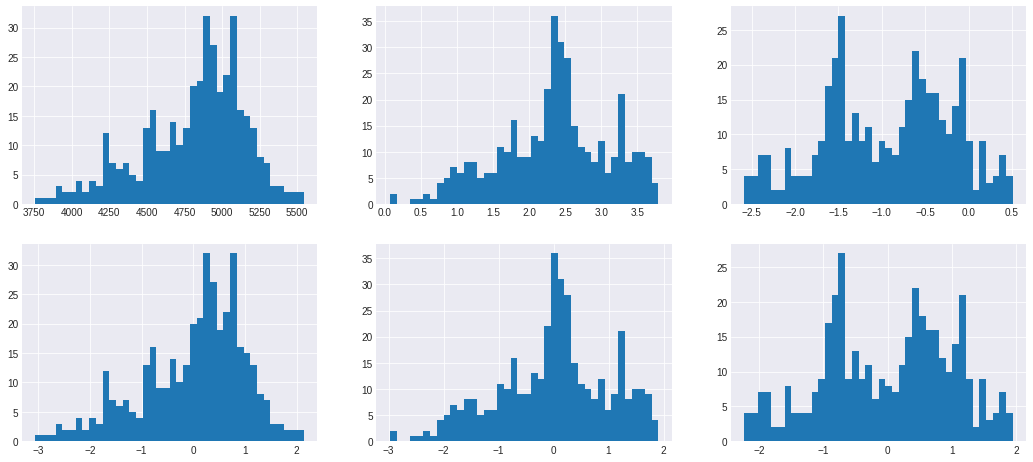

In [86]:
fig, ax = plt.subplots(2, 3, figsize=(18,8))
for i in range(3):
    ax[0,i].hist(labels[:,i], bins=40)
    ax[1,i].hist(output_train_scaled[:,i], bins=40)

In [87]:
opti = optimizers.adam(amsgrad=True, lr=0.0001)
def nn_clf():
    model = Sequential()
    model.add(Dense(32, input_shape=(nr_pixels,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(32,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(3, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_absolute_error',  metrics=['mae',"mse"])
    return model
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                114496    
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 99        
Total params: 115,651
Trainable params: 115,651
Non-trainable params: 0
_________________________________________________________________


## 3.1 Looking for optimal number of epochs
We will first run the network we outlied above for a very large number of epoch, to estimate when overfitting starts occuring. This will be used as a guideline for chosing an epoch number in the actual simulation. As we can see from the plot above, the validation loss (green) has minimums (red dots) in the 16000-20000 range. We chose to train our actual network for 16000 iterations.

In [91]:
history = History()
clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=20000, callbacks=[history], validation_split=0.30, verbose=0)
history = clf.fit(input_train, output_train_scaled)

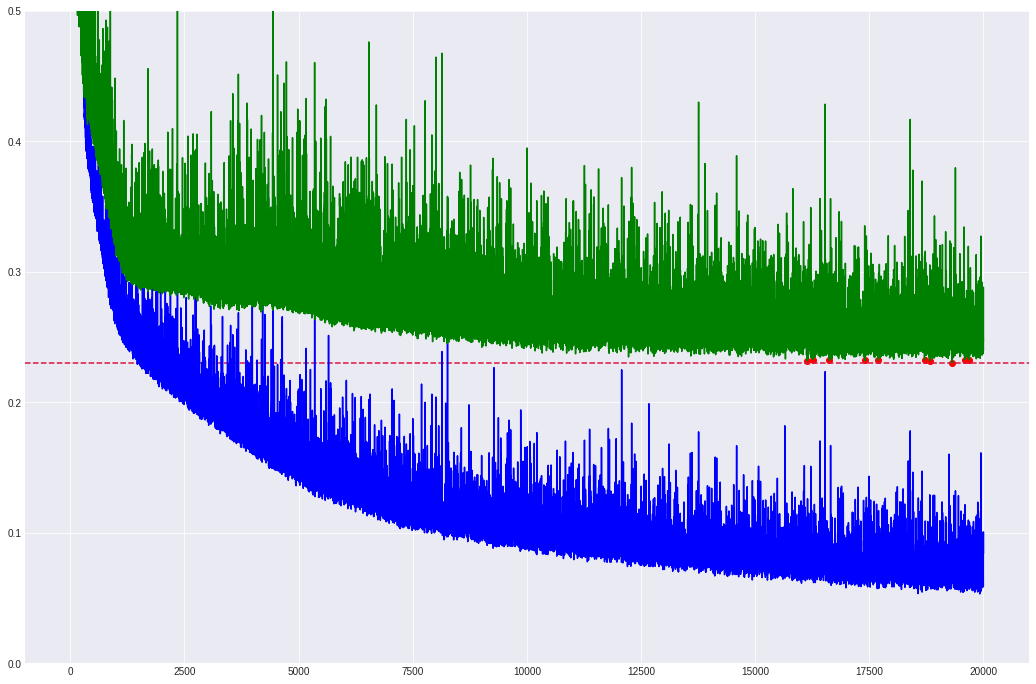

In [92]:
plt.figure(figsize=(18,12))
MSE = np.array(history.history['mean_absolute_error'])
val_MSE = np.array(history.history['val_mean_absolute_error'])
plt.ylim(0, 0.5)
asdf = np.argsort(val_MSE)[:10]
plt.axhline(y=val_MSE[asdf[0]], c="crimson", ls="--")
plt.plot(MSE, c="b")
plt.plot(val_MSE, c="g")
plt.scatter(asdf, val_MSE[asdf], c="r")

## 3.2 Take 10% out validation on our dataset.
With the network structure chosen, all that remains is to train the network and see how well it performs. We will do this in the spirit of "take 1 out" validation, where the network is trained on all but one datapoint, and then tested on this last datapoint. This is then repeated for all datapoints. We can't really afford to wait that long, and will perform a slightly simplified version, where 10% of the data is left out and tested on. This is repeated 10 times, until all the data has been tested on. This is performed in the code below.

In [94]:
all_input = mags_norm_poly2.copy()
all_output = labels.copy()
star_idxs = np.arange(0, nr_stars, 1)
np.random.shuffle(star_idxs)

all_predicted_output = []
all_actual_output = []
histories = []

factor = nr_stars//10
for i in range(10):
    if i < 9:
        test_idxs = star_idxs[i*factor:(i+1)*factor]
    else:
        test_idxs = star_idxs[i*factor:]
    input_test = all_input[test_idxs]
    input_train = np.delete(all_input, test_idxs, axis=0)
    output_test = all_output[test_idxs]
    output_train = np.delete(all_output, test_idxs, axis=0)
    
    Scaler = preprocessing.StandardScaler()
    Scaler.fit(output_train)
    output_train_scaled = Scaler.transform(output_train)
    output_test_scaled = Scaler.transform(output_test)

    clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=16000)
    history = clf.fit(input_train, output_train_scaled, verbose=0)
    histories.append(history)
    print(history.history['mean_squared_error'][-1])
    
    predicted = clf.predict(input_test)
    all_predicted_output.extend(Scaler.inverse_transform(predicted))
    all_actual_output.extend(output_test)
all_predicted_output = np.array(all_predicted_output)
all_actual_output = np.array(all_actual_output)

0.02121125838835394
0.02609691762882509
0.017989840105218185
0.025839896001668368
0.02277682867249416
0.017826024858444593
0.018778642333474104
0.01585078803511078
0.024283377296705506
0.014070867775724484


## 3.3 Results
The results of the take 10% out validation is shown below. In the top 3 panels, the SSPP labels are shown compared to ASPCAP. ASPCAP labels are along the x-axis, with deviations from these values along the y-axis. The three bottom panels are our model. Both top and bottom go in order "Teff, Log(g), Fe/H".

As we can see, our model lies slightly closer to ASPCAP than SSPP does in all three labels. This is especially true for the effective temperature, where SSPP and ASPCAP values more strongly disgareed than in the other cases.

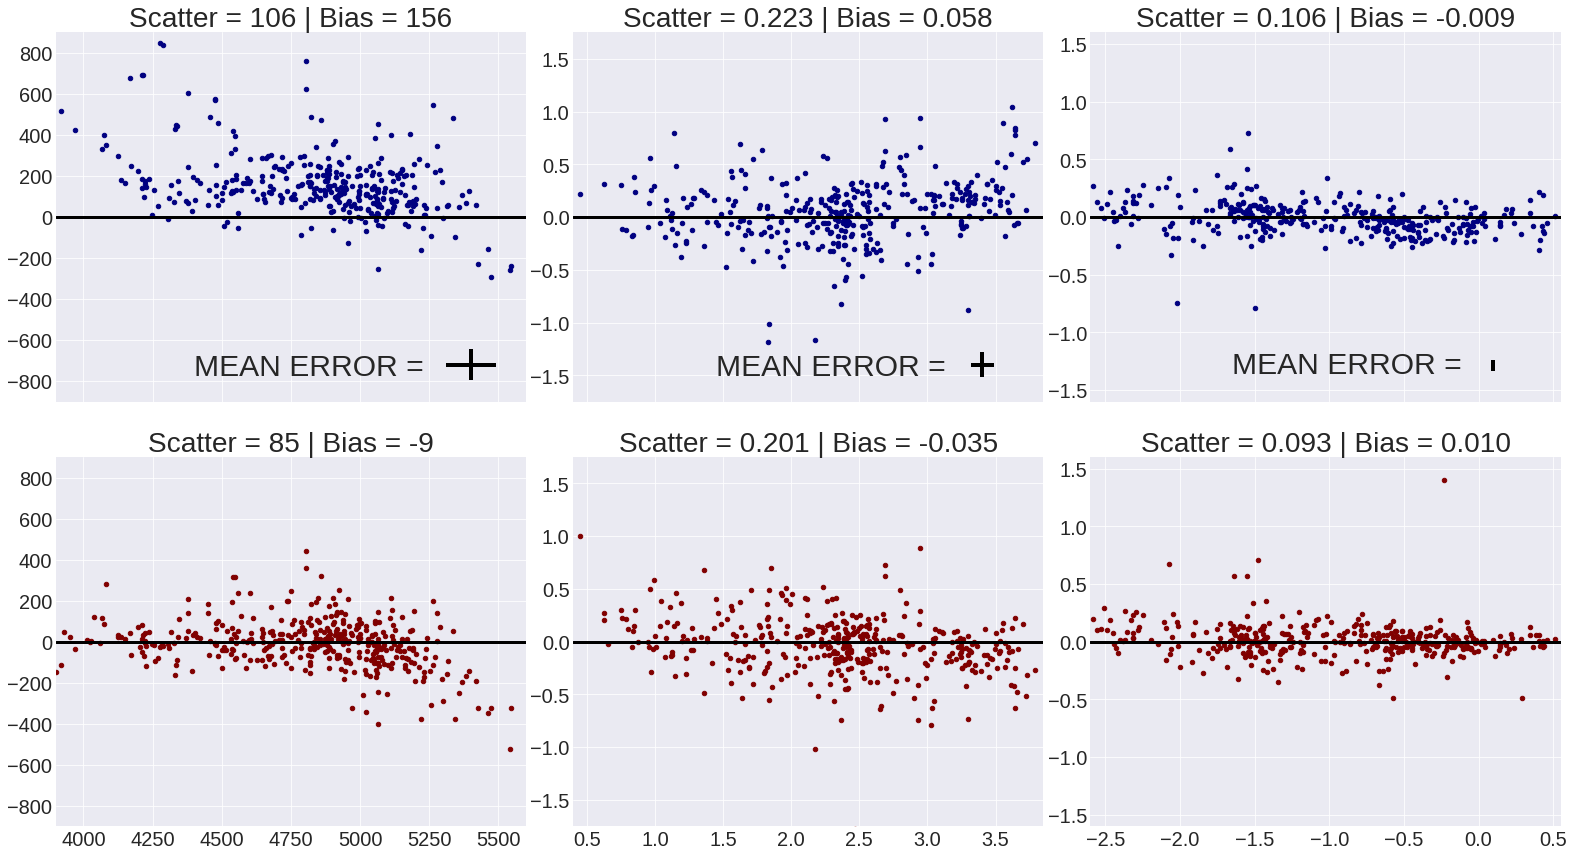

In [153]:
label_ylims = [[-900, 900], [-1.75, 1.75], [-1.6, 1.6]]
bar_loc = [[5400, -720], [3.4, -1.4], [0.1, -1.29]]
text_loc = [[4400, -770], [1.45, -1.5], [-1.65, -1.35]]
label_digits = [0, 3, 3]


biases = np.sum(all_predicted_output - all_actual_output, axis=0)/nr_stars
scatters = np.mean(np.abs(all_predicted_output - biases - all_actual_output), axis=0)
biases_str = [f"{biases[0]:.0f}", f"{biases[1]:.3f}", f"{biases[2]:.3f}"]
scatters_str = [f"{scatters[0]:.0f}", f"{scatters[1]:.3f}", f"{scatters[2]:.3f}"]

biases_SSPP_str = [f"{biases_SSPP[0]:.0f}", f"{biases_SSPP[1]:.3f}", f"{biases_SSPP[2]:.3f}"]
scatters_SSPP_str = [f"{scatters_SSPP[0]:.0f}", f"{scatters_SSPP[1]:.3f}", f"{scatters_SSPP[2]:.3f}"]

fig, ax = plt.subplots(2, 3, figsize=(22,12), sharex='col')
for i, l in enumerate(['Teff', 'logg', 'FeH']):
    ax[0,i].scatter(APOGEE[l], SSPP[l+'_diff'], s=20, c="navy", label=""); ax[0,i].set_title(f"Scatter = {scatters_SSPP_str[i]} | Bias = {biases_SSPP_str[i]}", fontsize=28)
    ax[1,i].scatter(all_actual_output[:,i], all_predicted_output[:,i]-all_actual_output[:,i], s=20, c="maroon"); ax[1,i].set_title(f"Scatter = {scatters_str[i]} | Bias = {biases_str[i]}", fontsize=28);
    ax[0,i].set_xlim(*label_xlims[i]); ax[1,i].set_xlim(*label_xlims[i])
    ax[0,i].set_ylim(*label_ylims[i]); ax[1,i].set_ylim(*label_ylims[i])
    ax[0,i].axhline(y=0, c="black", lw=3); ax[1,i].axhline(y=0, c="black", lw=3)
    ax[0,i].errorbar(*bar_loc[i], fmt=",", lw=4, yerr=np.mean(SSPP[f'{l}_err']), xerr=np.mean(APOGEE[f'{l}_err']), c="black")
    ax[0,i].text(*text_loc[i], "MEAN ERROR = ", fontsize=30)

mpl.rc('xtick', labelsize=20)     
mpl.rc('ytick', labelsize=20)
plt.tight_layout();
fig.subplots_adjust(hspace=0.15, wspace=0.1);

# 4. Conclusion
We have successfully created a model which predicts labels more in line with ASPCAP than the established SSPP labels do. If we believe the ASPCAP labels to be of better quality, one could argue that our model outperforms SSPP (if not by very much, at least in Log(g) and Fe/H). The model has lots of room for expansion, both in terms of more input parameters, metadata and not just spectra could be included. Expanding the output label space to abundances would also be of great interest.

The comparison between ASPCAP and SSPP was also very interesting in itself. Besides the obvious bias in effective temperature, the other labels holds interesting stories of their own. For instance, while the Fe/H results agree a lot more than effective temperature between the two pipelines, the reported errors are also much smaller, and in sigma terms, the disagreement in Fe/H is actually huge. Whether this is underreported errors or something else is hard to say.

# 5. Appendix: Hyperparameter Optimization
We performed a simple hyperparameter optimization using the Talos module. A range of hyperparameters were chosen, and a 25% random subset of these were actually run. Ideally, we would have run a much larger range of the parameters, but it gave us some idea of what performed better. The final results are printed in a table below, sorted after validation loss. While we ended up running for way too few epoch, we learned that relu outperformed elu as an optimizer, 2 hidden layers perform the best (mistakenly printed as 1 hidden layer, which should read "1 extra hidden layer"). The hidden layers also performed best with 32 neurons. A learning rate of 0.0001 also outperformed the higher ones. The differences were small, and, as mentioned, we should ideally have done a much more exhaustive search, but it give us some nice guidelines to base our layout on.

In [230]:
import talos as ta
from talos.model.layers import hidden_layers
from keras.activations import relu, elu, linear

p = {
    'dropout' : [0],
    'hidden_layers' : [1, 2, 4],
    'neuron_size' : [18, 24, 32],
    'activation' : [relu, elu],
    'batch_size' : [8, 16, 32],
    'epochs' : [3000, 4000, 6000],
    'lr' : [0.0001, 0.0003, 0.0005]
}

def input_model(x_train, y_train, x_val, y_val, params):
    Scaler = preprocessing.StandardScaler()
    y_train_scaled = Scaler.fit_transform(y_train)
    y_val_scaled = Scaler.transform(y_val)
    
    opti = optimizers.adam(amsgrad=True, lr=params['lr'])

    model = Sequential()
    model.add(Dense(params['neuron_size'], input_shape=(nr_pixels,), activation="linear", kernel_initializer='random_uniform'))
    for i in range(params['hidden_layers']):
        model.add(Dense(params['neuron_size'], activation=params['activation'], kernel_initializer='random_uniform'))
    model.add(Dense(3, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    out = model.fit(x_train, y_train_scaled,
                batch_size=params['batch_size'],
                epochs=params['epochs'],
                verbose=0,
                validation_data=[x_val, y_val_scaled])
    return out, model

In [ ]:
x, y = mags_norm_poly2, labels

h = ta.Scan(x, y,
            params=p,
            dataset_name='first_test',
            experiment_no='aaa',
            model=input_model,
            grid_downsample=0.25)
h.to_csv("hyperparam.csv")

In [28]:
h = pd.read_csv("hyperparam.csv")
h.sort_values(by="val_loss")

Unnamed: 0  round_epochs  val_loss  val_mean_absolute_error  \
21          21          6000  0.082141                 0.188204   
33          33          6000  0.084844                 0.193203   
23          23          4000  0.085589                 0.192056   
16          16          4000  0.085806                 0.196162   
12          12          4000  0.086855                 0.198207   
24          24          6000  0.086887                 0.198002   
18          18          6000  0.087320                 0.192272   
43          43          4000  0.087508                 0.195467   
37          37          4000  0.087538                 0.194418   
34          34          4000  0.087819                 0.194825   
29          29          6000  0.087949                 0.194666   
22          22          6000  0.087981                 0.207365   
19          19          6000  0.088018                 0.194544   
30          30          4000  0.088389                 0.196988   
40          40          4000  0.088494                 0.201117   
45          45          6000  0.088526                 0.194905   
32          32          4000  0.088650                 0.194697   
26          26          6000  0.089336                 0.199112   
10          10          3000  0.089427                 0.212957   
31          31          3000  0.089934                 0.202240   
3            3          6000  0.090886                 0.211829   
38          38          3000  0.091678                 0.200519   
17          17          3000  0.091754                 0.207255   
47          47          3000  0.091878                 0.205892   
28          28          6000  0.092343                 0.218728   
0            0          3000  0.093352                 0.216013   
5            5          6000  0.094456                 0.202193   
42          42          6000  0.094492                 0.209698   
9            9          4000  0.095286                 0.212051   
2            2          6000  0.096541                 0.211864   
25          25          3000  0.096583                 0.213445   
35          35          3000  0.096682                 0.219334   
7            7          4000  0.097055                 0.215016   
15          15          3000  0.097191                 0.214319   
44          44          6000  0.097562                 0.213855   
13          13          4000  0.097769                 0.214449   
6            6          4000  0.098096                 0.214647   
27          27          3000  0.098205                 0.218688   
20          20          3000  0.098294                 0.216995   
41          41          3000  0.100144                 0.217822   
8            8          3000  0.101030                 0.223580   
36          36          6000  0.102499                 0.225142   
46          46          3000  0.102865                 0.222183   
4            4          3000  0.104022                 0.217375   
1            1          3000  0.104401                 0.230399   
14          14          3000  0.105684                 0.232786   
39          39          3000  0.107541                 0.236332   
11          11          4000  1.132114                 0.858160   

    val_mean_squared_error      loss  mean_absolute_error  mean_squared_error  \
21                0.082141  0.018071             0.093705            0.018071   
33                0.084844  0.025831             0.111774            0.025831   
23                0.085589  0.016556             0.093542            0.016556   
16                0.085806  0.024628             0.111867            0.024628   
12                0.086855  0.018519             0.096604            0.018519   
24                0.086887  0.015932             0.090361            0.015932   
18                0.087320  0.009268             0.065241            0.009268   
43                0.087508  0.023481             0.108608            0.0